In [172]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import sys
import os
import json
import matplotlib.lines     as mlines
import tqdm
from scipy.stats    import gmean
import torch
from torch.autograd.functional import jacobian
from time import time
from natsort                import natsorted
from matplotlib.ticker import FixedLocator


from matplotlib          import rcParams, rc
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 10})
rc('font', family='serif')
rc('text', usetex=True)
# plt.rcParams['figure.dpi'] = 150

## import own functions
sys.path.insert(1, '/STER/silkem/MACE/src/mace')

import src.mace.CSE_0D.dataset          as ds
import src.mace.CSE_0D.intregr_train    as tr
import src.mace.neuralODE               as nODE
from src.mace.CSE_0D.loss               import Loss
import src.mace.CSE_0D.loss             as loss
import src.mace.CSE_0D.plotting         as pl
import src.mace.utils                   as utils
# from src.mace.neuralODE    import Solver

def temp(Tstar, eps, r):
    Rstar = 2e13
    # r = 1e16
    T = Tstar * (r/Rstar)**(-eps)
    return T

specs_dict, idx_specs = utils.get_specs()

%reload_ext autoreload
%autoreload 2

### Testing input file mace_training_routine

In [84]:
inFile = '/STER/silkem/MACE/input/input_test.txt'
with open(inFile,'r') as f:
    file = f.readlines()
    lines = []
    for line in file:
        lines.append(line.split())

inputfile = {}
for i in range(len(lines)):
    if not len(lines[i]) == 0 and len(lines[i]) > 2:
        # print(test[i])
        inputfile[lines[i][0]] = lines[i][2]
    elif not len(lines[i]) == 0 and len(lines[i]) <= 2:
        print('You forgot to give an input for '+lines[i][0])

## SET PARAMETERS
lr          = float(inputfile['lr'])
tot_epochs  = int(inputfile['tot_epochs'])
nb_epochs   = int(inputfile['nb_epochs'])
ini_epochs  = 5
losstype    = inputfile['losstype']
z_dim       = int(inputfile['z_dim'])
batch_size  = 1
nb_samples  = int(inputfile['nb_samples'])
n_dim       = 468

### Retrieving the min & max values of the dataset

In [79]:
## density
rho_min = np.inf
rho_max = 0
## temperature
T_max = 0
## delta
delta_min = np.inf
delta_max = 0
## Av
Av_min = np.inf
Av_max = 0

dt_max = 0


lens = dict()

for i, path in enumerate(inputdirs):
    print(i, end='\r')

    mod = ds.CSEmod(path)

    ## check the length of the model
    if len(mod) != 135:
        lens[i] = len(mod)
    
    ## check the min and max of the parameters
    ## density
    rho_min_mod = min(mod.get_dens())
    rho_max_mod = max(mod.get_dens())
    if rho_min_mod < rho_min:
        rho_min = rho_min_mod
    if rho_max_mod > rho_max:
        rho_max = rho_max_mod
    ## Av
    Av_min_mod = min(mod.get_Av())
    Av_max_mod = max(mod.get_Av())
    if Av_min_mod < Av_min:
        Av_min = Av_min_mod
    if Av_max_mod > Av_max:
        Av_max = Av_max_mod
    ## temperature
    T_max_mod = max(mod.get_temp())
    if T_max_mod > T_max:
        T_max = T_max_mod
    ## delta
    delta_min_mod = min(mod.get_delta())
    delta_max_mod = max(mod.get_delta())
    if delta_min_mod < delta_min:
        delta_min = delta_min_mod
    if delta_max_mod > delta_max:
        delta_max = delta_max_mod

    ## dt
    dt_max_mod = max(mod.get_dt())
    if dt_max_mod > dt_max:
        dt_max = dt_max_mod

    


In [80]:
## density
print('dens:',rho_min, rho_max)
## temperature
print('temp: 10',T_max)
## delta
print('delta',delta_min, delta_max)
## Av
print('Av',Av_min, Av_max)

print('dt',dt_max)

dens: 0.008223 5009000000.0
temp: 10 1851.0
delta 0.0 0.9999
Av 2.141e-05 1246.0
dt 434800000000.0


In [83]:
meta = {'dens_min': rho_min,
        'dens_max': rho_max,
        'temp_min': 10.,
        'temp_max': T_max,
        'delta_min': delta_min,
        'delta_max': delta_max,
        'Av_min': Av_min,
        'Av_max': Av_max,
        'dt_max': dt_max
        }


json_object = json.dumps(meta, indent=4)
with open("/STER/silkem/MACE/data/minmax.json", "w") as outfile:
    outfile.write(json_object)

### Testing the dataset class

In [3]:
inputdirs = np.loadtxt('data/paths_data_C.txt', dtype=str)

In [4]:
len(inputdirs)

18314

In [15]:
inputdirs[-1]

'/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v20_T_eps/models/model_2023-01-10h12-19-34/csfrac_smooth.out'

In [13]:
for i, path in enumerate(inputdirs):
    print(i, path, end='\r')
    # try:
    mod = ds.CSEmod(path)
    # except Exception as e:
    #     print(e)
    #     print("does not exist",i, path)


In [73]:
mod = ds.CSEmod(inputdirs[18241])
dt,n,p = mod.split_in_0D()

In [41]:
dt.shape, n.shape, p.shape

((80,), (81, 468), (80, 4))

In [42]:
n = n.reshape(81,468)
n.shape

(81, 468)

In [44]:
n[:-1].shape, n[1:].shape

((80, 468), (80, 468))

In [7]:
mod1 = ds.CSEmod(inputdirs[17982])
mod2 = ds.CSEmod(inputdirs[18241])
len(mod1), len(mod2)

(135, 81)

In [90]:
dt1, n1, p1 = mod1.split_in_0D()
dt2, n2, p2 = mod2.split_in_0D()

In [91]:
dt1.shape, n1.shape, p1.shape, dt2.shape, n2.shape, p2.shape


((134,), (134, 468), (134, 4), (80,), (80, 468), (80, 4))

In [93]:
h = np.concatenate((dt1, dt2), axis=0)
h.shape

(214,)

In [33]:
def generate_random_numbers(n, start, end):
    return np.random.randint(start, end, size=n)

# Generate 10 random integers between 1 and 100
random_numbers = generate_random_numbers(10, 1, 100)

In [68]:
dt, n, p = mod.split_in_0D()
delta = p[:,2]
# norm_delta = utils.normalise(np.log10(p[:,2]), np.log10(1e-100), np.log10(1e-100+0.999))
# norm_dens = utils.normalise(mod.)
# norm_delta

delta



array([7.226e-84, 1.930e-78, 2.241e-73, 1.196e-68, 3.093e-64, 4.071e-60,
       2.854e-56, 1.113e-52, 2.514e-49, 3.414e-46, 2.887e-43, 1.570e-40,
       5.665e-38, 1.393e-35, 2.396e-33, 2.953e-31, 2.664e-29, 1.795e-27,
       9.210e-26, 3.659e-24, 1.144e-22, 2.860e-21, 5.795e-20, 9.643e-19,
       1.335e-17, 1.555e-16, 1.542e-15, 1.315e-14, 9.743e-14, 6.327e-13,
       3.634e-12, 1.861e-11, 8.565e-11, 3.569e-10, 1.355e-09, 4.723e-09,
       1.519e-08, 4.532e-08, 1.262e-07, 3.294e-07, 8.095e-07, 1.881e-06,
       4.147e-06, 8.708e-06, 1.747e-05, 3.356e-05, 6.195e-05, 1.101e-04,
       1.890e-04, 3.137e-04, 5.047e-04, 7.888e-04, 1.200e-03, 1.778e-03,
       2.573e-03, 3.641e-03, 5.045e-03, 6.855e-03, 9.145e-03, 1.199e-02,
       1.548e-02, 1.968e-02, 2.468e-02, 3.053e-02, 3.732e-02, 4.508e-02,
       5.388e-02, 6.373e-02, 7.465e-02, 8.666e-02, 9.974e-02, 1.139e-01,
       1.290e-01, 1.451e-01, 1.622e-01, 1.800e-01, 1.987e-01, 2.180e-01,
       2.380e-01, 2.585e-01, 2.795e-01, 3.008e-01, 

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-6_v15_T_eps/models/model_2022-12-24h10-24-32/csfrac_smooth.out


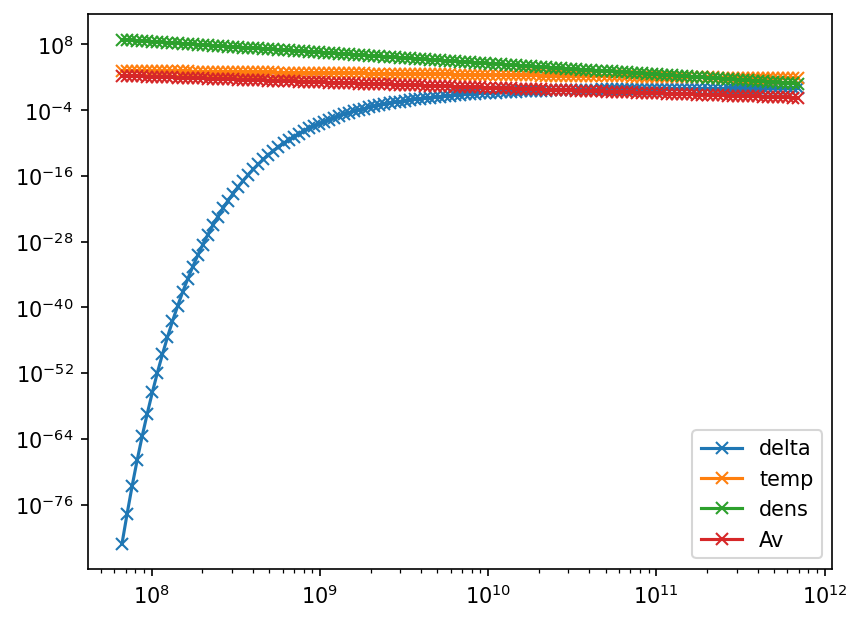

In [116]:
i = 2898-1
mod = ds.CSEmod(inputdirs[i])
print(inputdirs[i])


a=0.5

y = 0.01
# plt.loglog(mod.get_time(), mod.get_delta()+y, '-x', label = 'delta + '+str(y), alpha = a)
y = 1.e-40
# plt.loglog(mod.get_time(), mod.get_delta()+y, '-x', label = 'delta + '+str(y), alpha = a)
plt.loglog(mod.time, mod.get_delta(), '-x', label = 'delta')#, alpha = a)
plt.loglog(mod.get_time(), mod.get_temp(), '-x', label = 'temp')
plt.loglog(mod.get_time(), mod.get_dens(), '-x', label = 'dens')
plt.loglog(mod.get_time(), mod.get_Av(), '-x', label = 'Av')
# plt.loglog(mod.get_time(), mod.get_abs_spec('CO' ),label = 'CO')
# plt.loglog(mod.get_time(), mod.get_abs_spec('H2O'),label = 'H2O')
# plt.loglog(mod.get_time(), mod.get_abs_spec('CH4'),label = 'CH4')
# plt.loglog(mod.get_time(), mod.n[:,-2],label = 'e-')

plt.legend()
plt.show()

### Testing the training

In [121]:
## Set up PyTorch 
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} 

lr = 1.e-4
epochs = 100

losstype = 'mse_idn'
# losstype = 'mse'
z_dim = 8
dt_fract = 0.2
batch_size = 10000
nb_samples = 2
n_dim = 468
nb_hidden = 1
ae_type = 'simple'
nb_test = 3000

print('------------------------------')
print('      # epochs:', epochs)
print(' learning rate:', lr)
print('# z dimensions:', z_dim)
print('     # samples:', nb_samples)
print('     loss type:', losstype)
print('')


train, test, data_loader, test_loader = ds.get_data(dt_fract=dt_fract,nb_samples=nb_samples,nb_test = nb_test, batch_size=batch_size, kwargs=kwargs)

------------------------------
      # epochs: 100
 learning rate: 0.0001
# z dimensions: 8
     # samples: 2
     loss type: mse_idn

Dataset:
------------------------------
  total # of samples: 2
#   training samples: 1
# validation samples: 1
               ratio: 0.5
     #  test samples: 3000


In [3]:
model = nODE.Solver(p_dim=4,z_dim = z_dim, n_dim=n_dim,nb_hidden=nb_hidden, ae_type=ae_type, DEVICE = DEVICE)

num_params = utils.count_parameters(model)
print(f'The model has {num_params} trainable parameters\n')


norm = {'mse' : 1,
        'rel' : 1,
        'grd' : 1,
        'idn' : 1}

fract = {'mse' : 1, 
         'rel' : 1,
         'grd' : 1,
         'idn' : 1}


## Make loss objects
trainloss = Loss(norm, fract)
testloss  = Loss(norm, fract)

trainloss.set_losstype(losstype)
testloss.set_losstype(losstype)

tic = time()
opt = tr.train(model, lr, data_loader, test_loader,nb_evol = 44, path = None, end_epochs = epochs, DEVICE= DEVICE, trainloss=trainloss, testloss=testloss, start_time = time())
toc = time()

print('\nTraining time [s]:',toc-tic)




The model has 284692 trainable parameters

Model:         
learning rate: 0.0001
loss type:     mse_idn

>>> Training model...



KeyboardInterrupt: 

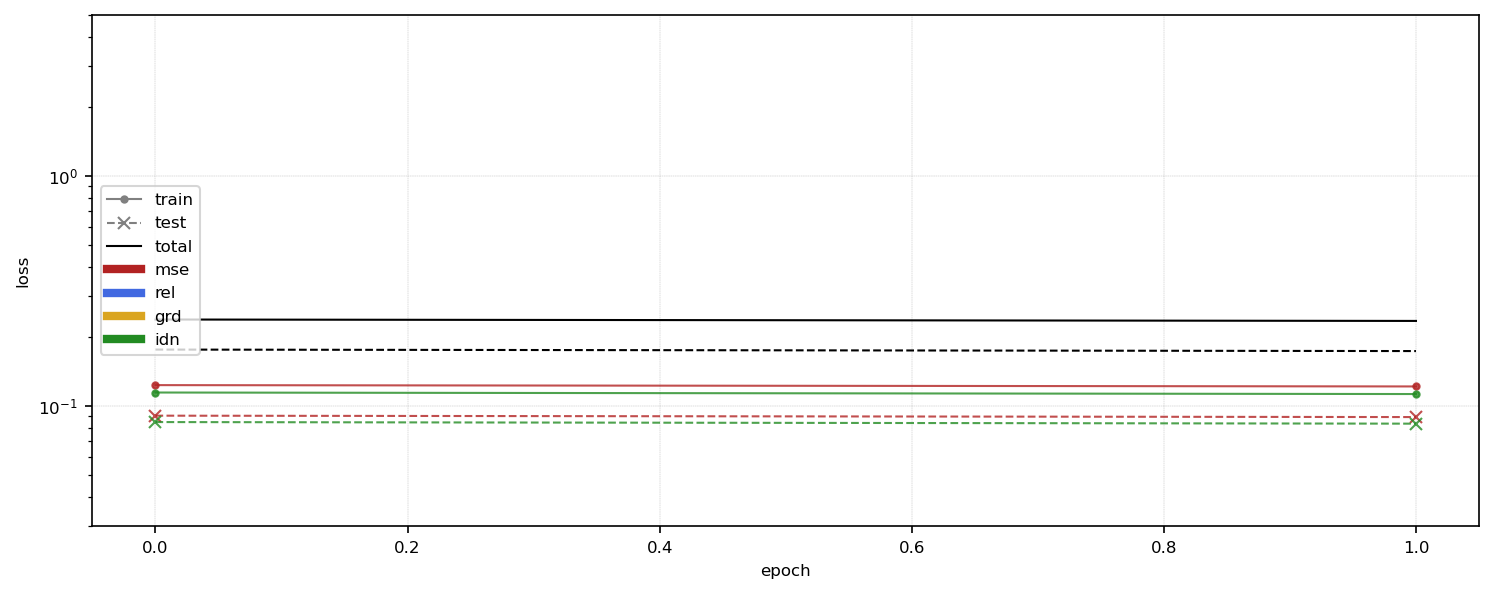

In [58]:
fig = pl.plot_loss(trainloss, testloss, log = True, ylim = True, limits = [3e-2,5e0])

plt.show()

### Testing & visualising integrated training

In [13]:
outloc  = '/STER/silkem/MACE/models/CSE_0D/old/'
print(train.path)

## other learning rates
dirname = '2023-12-13 18:19:22.522359'  ## lr = 1.e-4       GOOD MODEL

meta, model = utils.load_all_noevol(outloc, dirname, sepr = True, epoch = 7)   # type: ignore
tstep_evol = 25

for i, (n,p,dt) in enumerate(data_loader):
    # print(n.shape, p.shape, dt.shape)
    n  = n.view(n.shape[1], n.shape[2]).to(DEVICE)     ## op een niet-CPU berekenen als dat er is op de device
    p  = p.view(p.shape[1], p.shape[2]).to(DEVICE) 
    dt = dt.view(dt.shape[1]).to(DEVICE)

    # print(n.shape, p.shape, dt.shape)

   
    n0 = n[0:-tstep_evol]
    p0 = p[0:-tstep_evol]
    dt0 = dt[0:-tstep_evol]

    # print(n0.shape, p0.shape, dt0.shape)

    nhat_evol = list()
    n_evol = list()
    
    n_hat, z_hat, modstatus = model(n0[:-1],p0,dt0)   
    n_hat = n_hat.view(-1, 468)
    nhat_evol.append(n_hat)
    n_evol.append(n[0:-tstep_evol+0][:-1])

    print(n_hat.shape)

    ## subsequent steps of the evolution
    for i in range(1,tstep_evol):
        n_hat,z_hat, modstatus = model(n_hat,p[i:-tstep_evol+i],dt[i:-tstep_evol+i])   
        # print('shape nhat',n_hat.shape)
        n_hat = n_hat.view(-1, 468) 
        nhat_evol.append(n_hat)
        n_evol.append(n[i:-tstep_evol+i][:-1])

    nhat_evol = torch.stack(nhat_evol).permute(1,0,2)
    n_evol = torch.stack(n_evol).permute(1,0,2)

    # print(nhat_evol.shape, n_evol.shape)

    nhat_evol = nhat_evol.detach().numpy()
    n_evol = n_evol.detach().numpy()
    n = n.detach().numpy()


['/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-8_v10_T_eps/models/model_2022-12-23h17-45-41/csfrac_smooth.out']
The model has 76388 trainable parameters


torch.Size([109, 468])


In [16]:
nhat_evol.shape, n_evol.shape

((112, 22, 468), (112, 22, 468))

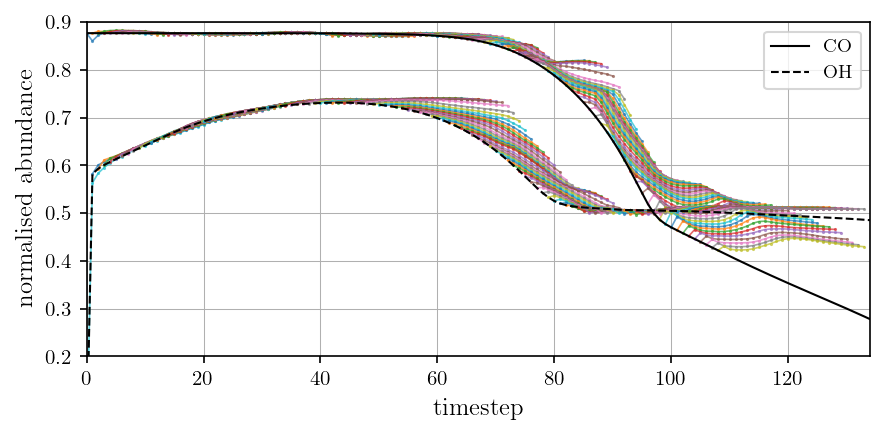

In [14]:
fig, ax1 = plt.subplots(figsize=(6,3))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

specs = ['CO', 'OH']


# ax1.set_title('Integrated MSE training')

ms = 0.5
lw = 0.8

if tstep_evol == 1:
    ms = 1.5

for spec in specs:
    idx = specs_dict[spec]

    for j in range(0,nhat_evol.shape[0]):
        n_sample_hat = nhat_evol[j]
        # print(j,n_sample_hat.shape, n[j].shape)
        n_sample_hat = np.concatenate((n[j].reshape(-1,len(n[j])),n_sample_hat))
        # print(j,n_sample_hat.shape, n[j].shape)
        n_sample = n_evol[j]
        ax1.plot(np.arange(j,j+tstep_evol+1),n_sample_hat.T[idx],'-o', alpha = 0.7, lw =lw, ms = ms)
        # ax1.plot(np.arange(j,j+tstep_evol), n_sample.T[idx])

idx = specs_dict['CO']
ax1.plot(n.T[idx], 'k-', lw = 1, label = 'CO')
idx = specs_dict['OH']
ax1.plot(n.T[idx], 'k--', lw = 1, label = 'OH')


ax1.set_xlabel('timestep',fontsize = 12)
ax1.set_ylabel('normalised abundance',fontsize = 12)

ax1.grid(True, linestyle = '-', linewidth = 0.5)

ax1.set_ylim(0.2,0.9)

ax1.set_xlim(0,134)

ax1.legend(fontsize = 9)
plt.tight_layout()
plt.savefig('visualisation_integrated_training_'+str(tstep_evol), dpi = 300)
plt.show()


### Testing trained models

In [122]:
len(train.testpath), train.testpath

(3000,
 ['/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v2-5_T_eps/models/model_2022-12-26h13-44-39/csfrac_smooth.out',
  '/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-8_v7-5_T_eps/models/model_2022-12-27h05-54-13/csfrac_smooth.out',
  '/lhome/silkem/CHEM/Output_nov2022/20210521_gridC_Mdot5e-5_v25_T_eps/models/model_2022-12-25h13-41-58/csfrac_smooth.out',
  '/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot5e-6_v20_T_eps/models/model_2022-12-27h13-16-10/csfrac_smooth.out',
  '/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-8_v5_T_eps/models/model_2022-12-27h15-59-44/csfrac_smooth.out',
  '/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot5e-8_v7-5_T_eps/models/model_2022-12-27h18-06-22/csfrac_smooth.out',
  '/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot2e-7_v17-5_T_eps/models/model_2022-12-28h13-40-55/csfrac_smooth.out',
  '/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v17-5_T_eps/models/model_2023-01-16h16-23-48/csfrac_smooth.o

The model has 284692 trainable parameters

META DATA
nb_samples 10000
lr 0.0001
epochs 250
z_dim 8
dt_fract 0.221
tmax 434800000000.0
train_time_h 122.65414042638407
overhead_s 2.02278995513916
samples 7000
cutoff_abs 1e-20
losstype mse_idn
inputfile test1
nb_evol 8
nb_hidden 1
ae_type simple
node pleiad08
done true

 Parameters tests:
-- 1e-08 -- 2.5 --
dens -13.397940008672037
temp 0.65 2700.0
     47.53716318676867
--

-- 5e-08 -- 12.5 --
dens -13.397940008672037
temp 0.7 2300.0
     29.678970558817944
--

-- 5e-08 -- 12.5 --
dens -13.397940008672037
temp 0.3 2150.0
     333.2325823228925
--



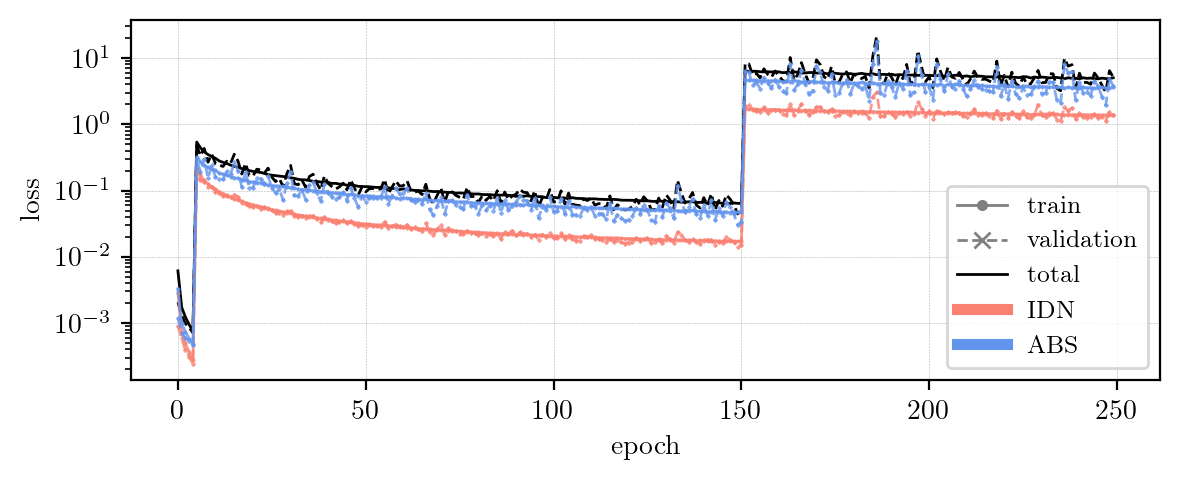

In [175]:
outloc  = '/STER/silkem/MACE/models/CSE_0D/'



## other learning rates
# dirname = '2023-12-13 18:19:22.522359'  ## lr = 1.e-4       GOOD MODEL

## local training
# dirname = '2024-01-03 12:39:49.464495'          # pt3
# dirname = '2024-01-03 12:39:43.621115_done'     #pt2
# dirname = '2024-01-02 21:42:45.793085_done'     #pt1

# dirname = '20240103_151253_58677_3'
# dirname = '20240103_235005_58677_7'
# meta, model_testing, trainloss_, testloss_ = utils.load_all_noevol(outloc, dirname) # type: ignore


## grid
dirname = '20240207_093243_66618_1'
# dirname = '20240207_134859_66656_2'


meta, model_testing, trainloss_, testloss_ = utils.load_all(outloc, dirname,epoch = '13') # type: ignore


print('\nMETA DATA')
for key in meta:
    print(key, meta[key])
    
plots_path = outloc+dirname+'/plots/'
utils.makeOutputDir(plots_path)

if not os.path.exists(outloc+dirname+"/testloss.json"):
    testloss = {}
    json_loss = json.dumps(testloss, indent=4)
    with open(outloc+dirname+"/testloss.json", "w") as outfile:
        outfile.write(json_loss)

# testpaths = ['/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-8_v2-5_T_eps/models/model_2022-12-26h16-02-06/csfrac_smooth.out',
            #  '/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-6_v17-5_T_eps/models/model_2022-12-24h17-06-51/csfrac_smooth.out',
            #  '/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot5e-5_v22-5_T_eps/models/model_2022-12-27h11-01-25/csfrac_smooth.out']

testpaths = ['/lhome/silkem/CHEM/Output_nov2022/20210518_gridC_Mdot1e-8_v2-5_T_eps/models/model_2022-12-24h21-58-23/csfrac_smooth.out', 
             '/lhome/silkem/CHEM/Output_nov2022/20210518_gridC_Mdot1e-8_v2-5_T_eps/models/model_2022-12-24h23-30-08/csfrac_smooth.out',
             '/lhome/silkem/CHEM/Output_nov2022/20210518_gridC_Mdot1e-8_v2-5_T_eps/models/model_2022-12-25h00-33-02/csfrac_smooth.out']

# testpaths = ['/lhome/silkem/CHEM/Output_nov2022/20210525_gridC_Mdot1e-8_v25_T_eps/models/model_2022-12-27h02-04-49/csfrac_smooth.out']

# testpaths = ['/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-7_v5_T_eps/models/model_2022-12-23h17-12-12/csfrac_smooth.out']
        
## check for difference in chem, same dens
# testpaths = ['/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-7_v5_T_eps/models/model_2022-12-24h12-55-54/csfrac_smooth.out',
#              '/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot5e-7_v12-5_T_eps/models/model_2022-12-27h12-24-10/csfrac_smooth.out',
#              '/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-6_v20_T_eps/models/model_2022-12-28h20-53-28/csfrac_smooth.out'
#              ]
testpaths = ['/lhome/silkem/CHEM/Output_nov2022/20210518_gridC_Mdot1e-8_v2-5_T_eps/models/model_2022-12-24h23-30-08/csfrac_smooth.out', 
             '/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v12-5_T_eps/models/model_2022-12-25h01-31-58/csfrac_smooth.out', 
              '/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v12-5_T_eps/models/model_2022-12-25h01-00-03/csfrac_smooth.out']

print('\n Parameters tests:')
for path in testpaths:
    # print(path)
    mod = ds.CSEmod(path)
    print('--', mod.Mdot,'--',mod.v/1e5, '--')
    print('dens', np.log10(mod.Mdot/mod.v))
    print('temp',mod.eps, mod.Tstar)
    print('    ', temp( mod.Tstar, mod.eps, 1e16))
    print('--')
    print()

fig = pl.plot_loss(trainloss_, testloss_, log = True, ylim = False, limits = [1e-4,1e1])#, notest = False)
plt.savefig(plots_path+'loss.png')




In [126]:
def test_model(model_testing, testpaths, specs_lg, specs, plots_path, save = False, plotting = False):
    # testpaths = train.testpath

    # testpaths = natsorted(testpaths)

    avg_step = list()
    std_step = list()
    sum_step = list()

    avg_evol = list()
    std_evol = list()
    sum_evol = list()

    mods = list()


    for i, testpath in enumerate(testpaths):
        print(i,testpath)
        input, info = ds.get_test_data(testpath,train)

        model1D = ds.CSEmod(testpath)
        r = model1D.radius
        rho = model1D.get_dens()
        T = model1D.get_temp()

        save = True
        title = info['path'] +'_'+ info['name']
        mods.append(title)

        n, n_hat, t, comptime = tr.test(model_testing, input)
        start_idx = 0
        n_evol, mace_time = tr.test_evolution(model_testing, input, start_idx=start_idx)

        print('\n>> Denormalising abundances...')
        n = ds.get_abs(n)
        n_hat = ds.get_abs(n_hat)
        n_evol = ds.get_abs(n_evol)

        print('\n>> Calculating & saving losses...')
        # print('per time step:')
        mse = loss.mse_loss(n[1:], n_hat)
        avg_step.append(mse.mean())
        std_step.append(mse.std())
        sum_step.append(mse.sum())
        losses_step = [mse.mean(), mse.std(), mse.sum()]

        # print('    evolution:')
        mse_evol = loss.mse_loss(n[1:], n_evol)
        avg_evol.append(mse_evol.mean())
        std_evol.append(mse_evol.std())
        sum_evol.append(mse_evol.sum())
        losses_evol = [mse_evol.mean(), mse_evol.std(), mse_evol.sum()]

        testloss = {title: losses_step,
                    title: losses_evol,
                    }
        
        with open(outloc+dirname+"/testloss.json", "r") as outfile:
            testloss_old = json.load(outfile)
        testloss_old.update(testloss)
        # print(testloss_old)
        with open(outloc+dirname+"/testloss.json", "w") as outfile:
            json.dump(testloss_old, outfile, indent=4)

        # plotting = False
        if plotting == True:
            print('\n>> Plotting...')

            ## --------------- Neural model - per time step ----------------- ##
            # pl.plot_compare(n, n_hat, plots_path, 'comp_timestep_'+title, alpha = 0.5, j = -1, save=True)
            pl.plot_abs( r,n, n_hat, plots_path, rho,T,'timestep_'+title,specs_lg, specs=specs, save=save, step = True)

            ## --------------- Neural model - evolution ----------------- ##

            # pl.plot_compare(n, n_evol, plots_path, 'comp_evolution_'+title, alpha = 0.5, j = -1, save=True)
            pl.plot_abs( r,  n, n_evol, plots_path, rho, T, 'evolution_'+title,specs_lg,specs=specs, save=save)

        print('Done!')
        print('----------------------------------------\n')

    return np.array(avg_step), np.array(std_step), np.array(sum_step), np.array(avg_evol), np.array(std_evol), np.array(sum_evol), mods

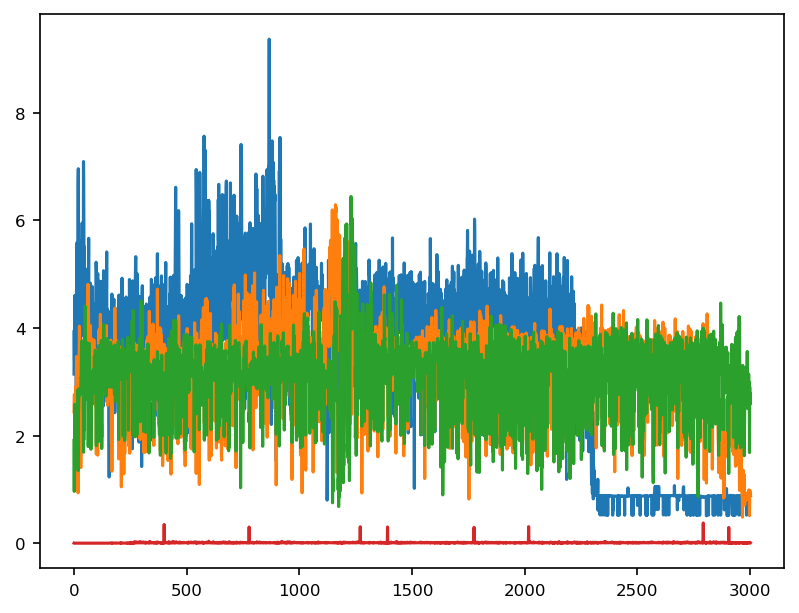

In [76]:
dirname = '20240106_102404_58729_3'
outloc  = '/STER/silkem/MACE/models/CSE_0D/'

time = np.load(outloc+dirname+'/calctime_evol_3002.npy')
plt.plot(time)


dirname = '20240106_102404_58729_4'
time = np.load(outloc+dirname+'/calctime_evol_3002.npy')
plt.plot(time)

dirname = '20240106_102404_58729_2'
time = np.load(outloc+dirname+'/calctime_evol_3002.npy')
plt.plot(time)

dirname = '20240109_173711_59121_1'
time = np.load(outloc+dirname+'/calctime_evol_3002.npy')
plt.plot(time)

________20240207_093243_66618_1_______________________________________________


0 /lhome/silkem/CHEM/Output_nov2022/20210518_gridC_Mdot1e-8_v2-5_T_eps/models/model_2022-12-24h23-30-08/csfrac_smooth.out
             Solving time [s]: 0.28755617141723633

>> Denormalising abundances...

>> Calculating & saving losses...

>> Plotting...
Done!
----------------------------------------

1 /lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v12-5_T_eps/models/model_2022-12-25h01-31-58/csfrac_smooth.out
             Solving time [s]: 0.9497129917144775

>> Denormalising abundances...

>> Calculating & saving losses...

>> Plotting...
Done!
----------------------------------------

2 /lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v12-5_T_eps/models/model_2022-12-25h01-00-03/csfrac_smooth.out
             Solving time [s]: 0.8699274063110352

>> Denormalising abundances...

>> Calculating & saving losses...

>> Plotting...
Done!
----------------------------------------



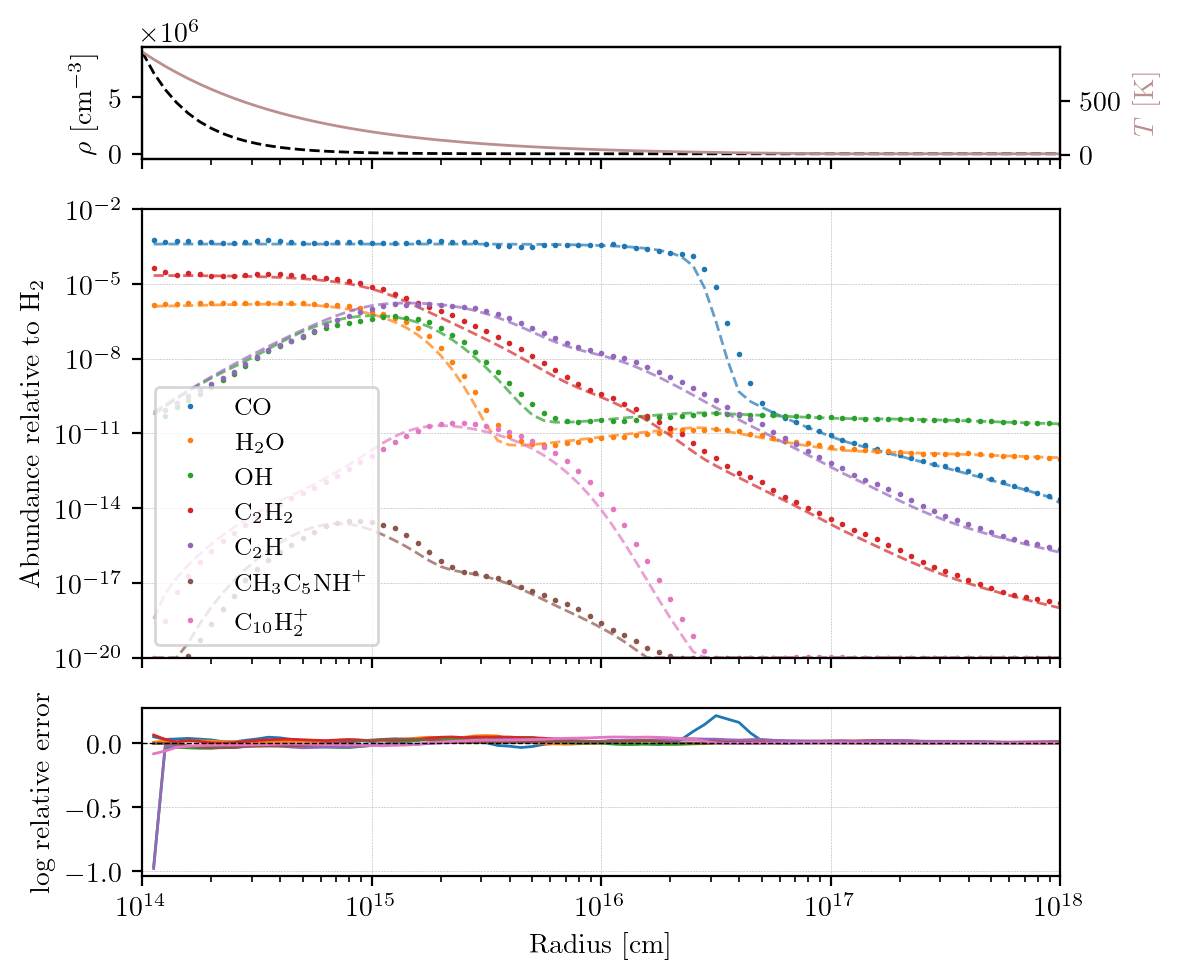

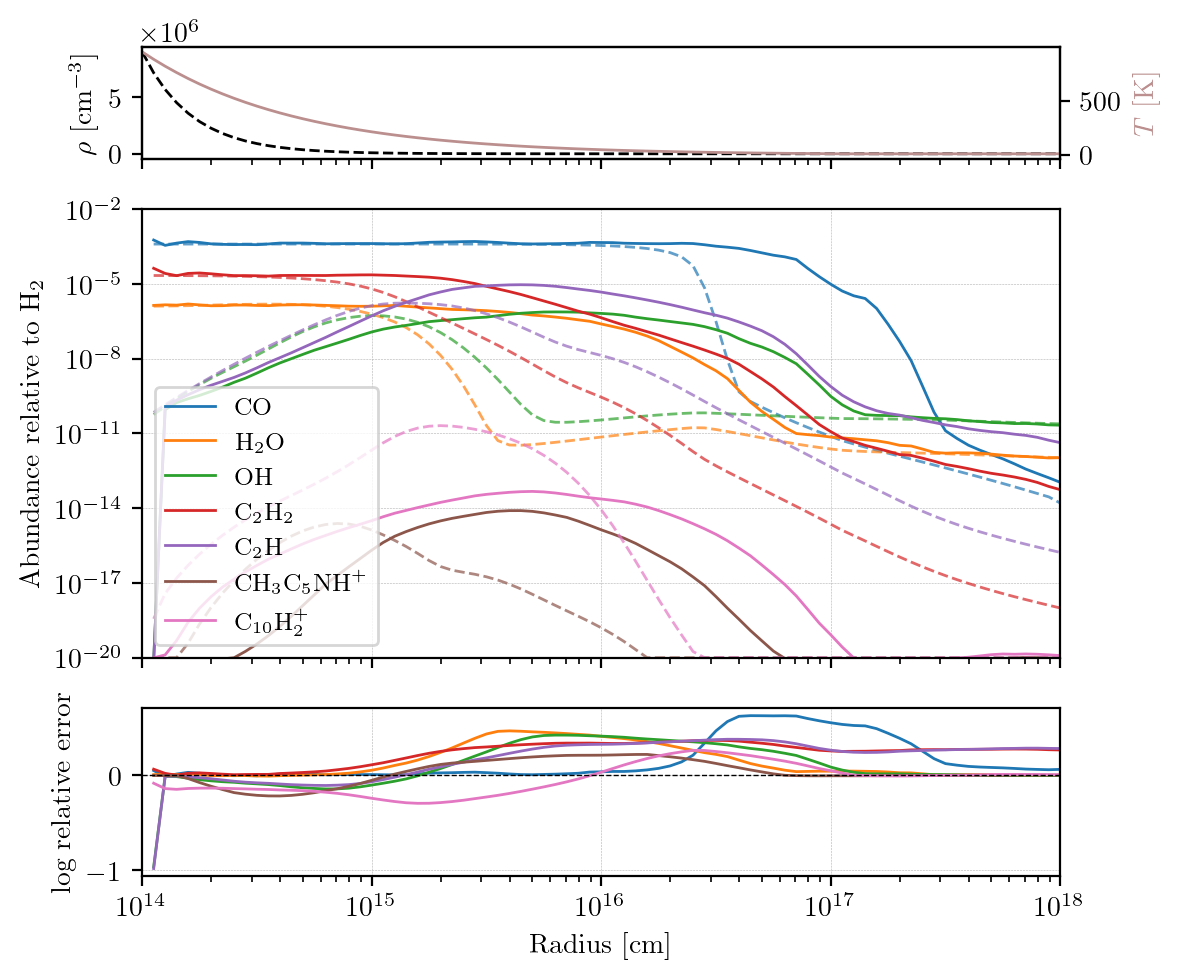

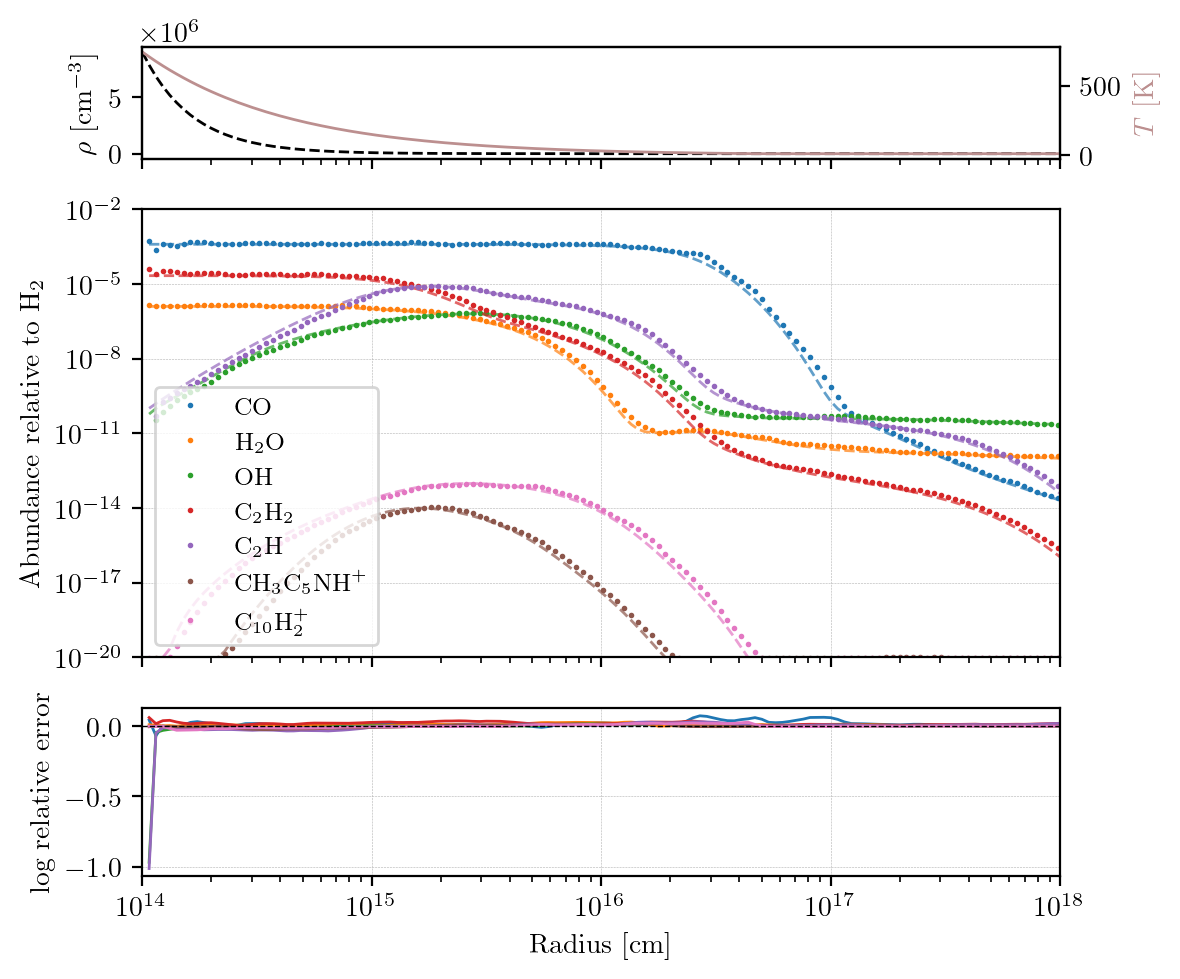

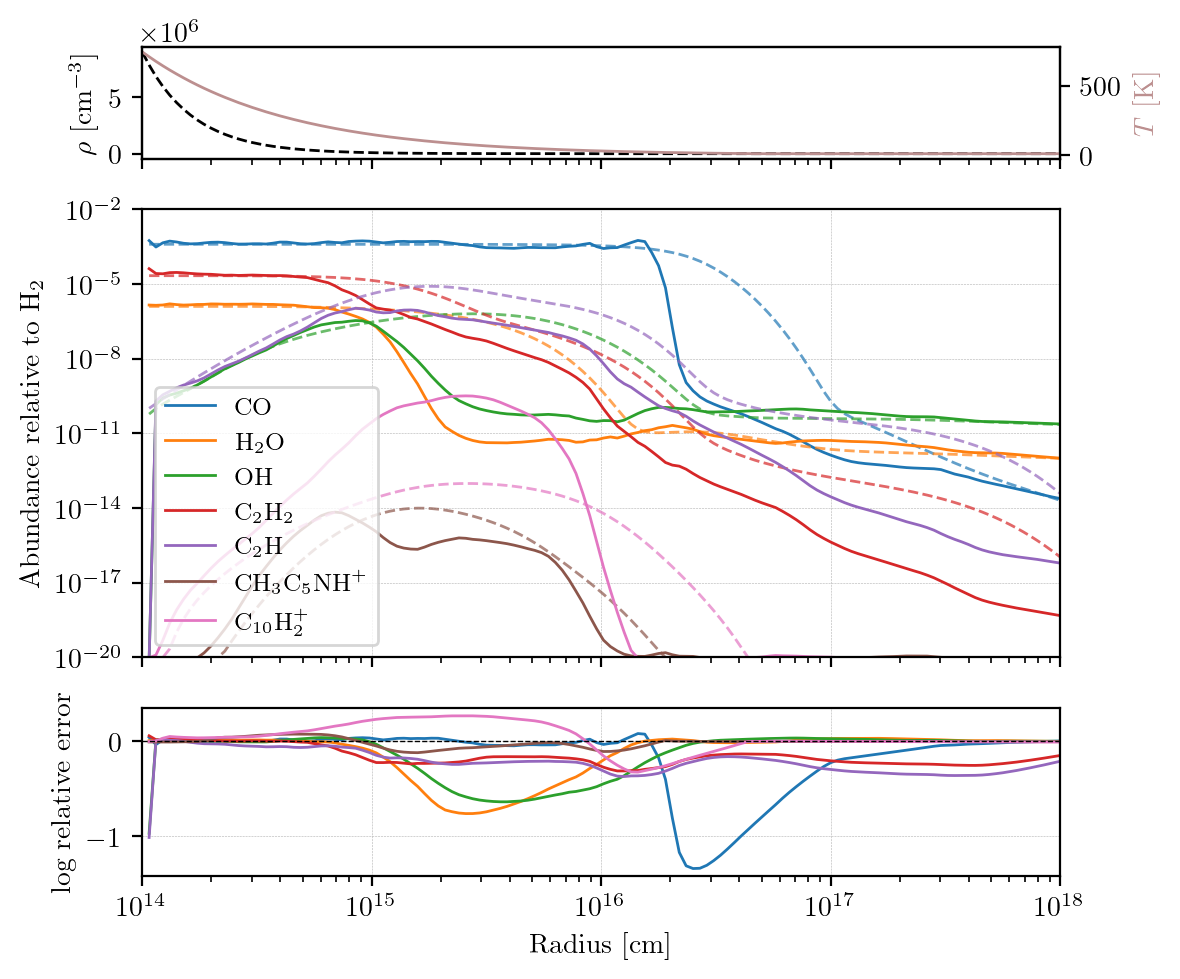

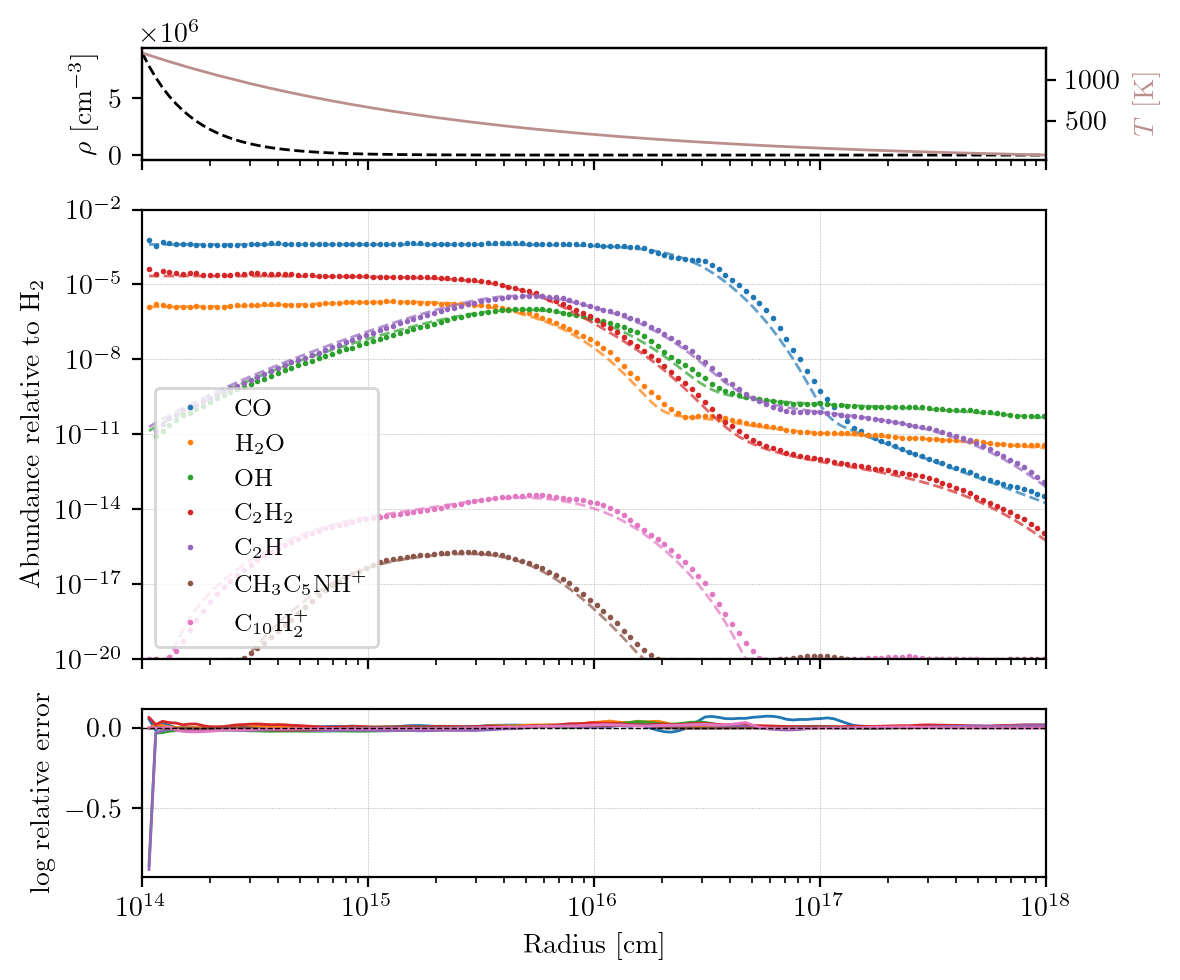

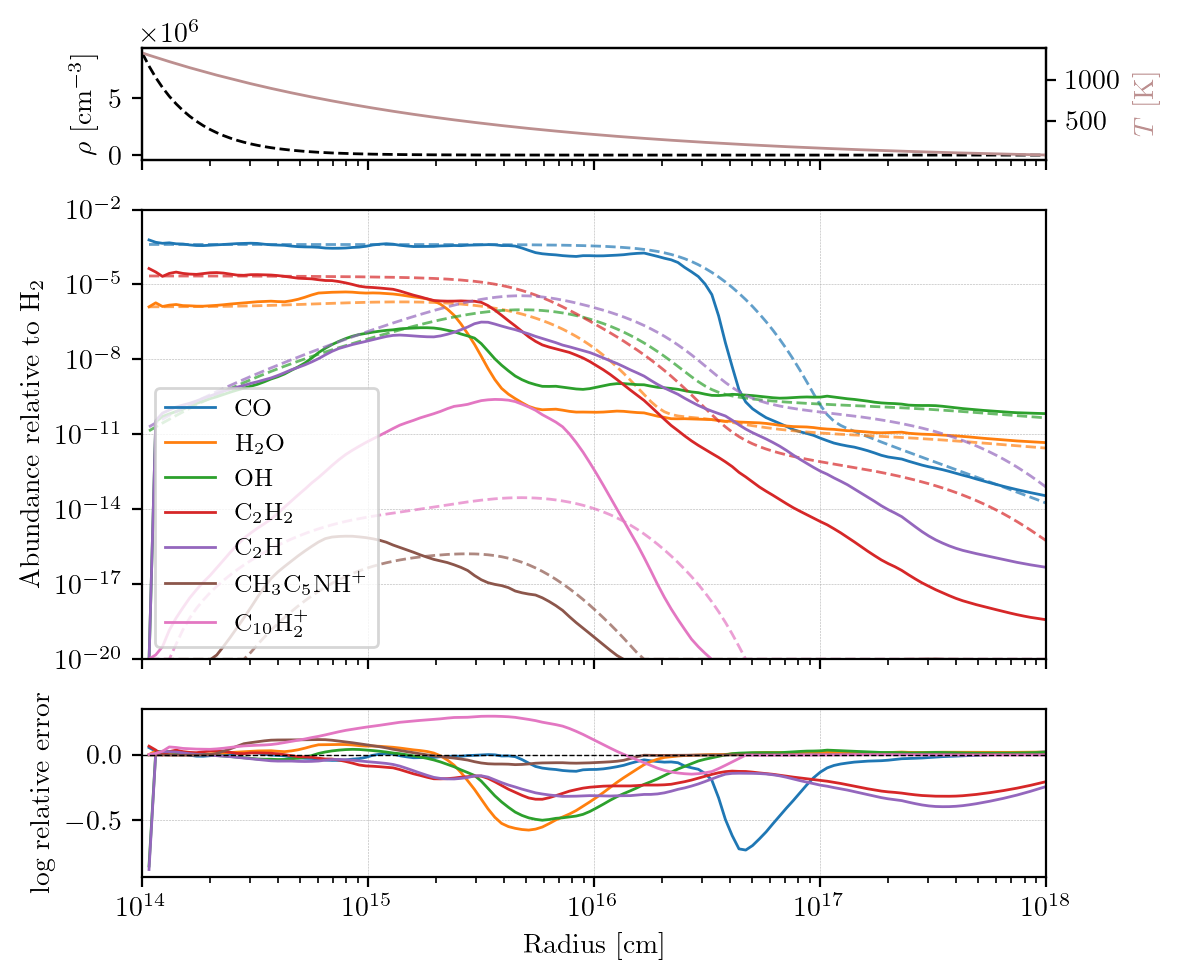

In [176]:
print('________'+dirname+'_______________________________________________\n\n')

specs = ['CO', 'H2O','OH',  'C2H2',  'C2H', 'CH3C5NH+', 'C10H2+']
specs_lg = {'CO': 'CO', 'H2O': 'H$_2$O','OH': 'OH',  'C2H2': 'C$_2$H$_2$',  'C2H': 'C$_2$H', 'CH3C5NH+': 'CH$_3$C$_5$NH$^+$', 'C10H2+': 'C$_{10}$H$_2^+$'}

plots_path = outloc+dirname+'/plots/'
utils.makeOutputDir(plots_path)

if not os.path.exists(outloc+dirname+"/testloss.json"):
    testloss = {}
    json_loss = json.dumps(testloss, indent=4)
    with open(outloc+dirname+"/testloss.json", "w") as outfile:
        outfile.write(json_loss)

avg_step, std_step, sum_step, avg_evol, std_evol, sum_evol, mods = test_model(model_testing, testpaths, specs_lg, specs = specs, plots_path = plots_path, save = True, plotting = True)
    

1012615979036056.6 598.5760228999213
18689.933194796 333.3561603826423
1868977802238.9587 339.22576150410686
72087.80608416465 601.3349462796604


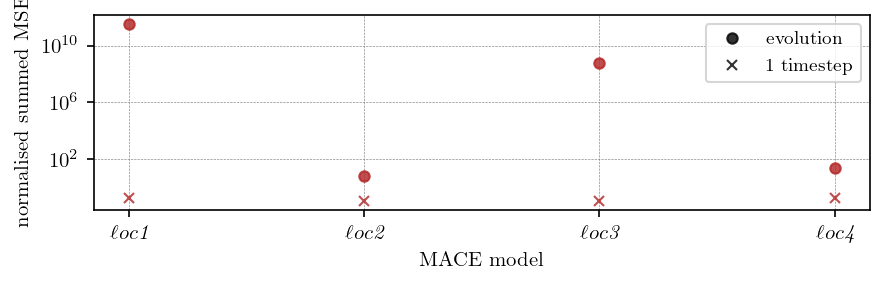

In [89]:
## LOCAL MODELS SUMMED MSE

idx = ['1', '3', '5']
outloc  = '/STER/silkem/MACE/models/CSE_0D/'

x = np.linspace(1,22,22)

fig = plt.figure(figsize = (6,2))
ax1 = fig.add_subplot((111))
lw = 0.5
handles = list()
losses_evol = list()
losses_step = list()    
dirs = list()

# ax1.set_title('Runs:58677')

idx = ['5']
for i in range(len(idx)):
    dirname = '20240103_151253_58677_'+idx[i]
    dirs.append(dirname)
    testloss_evol = np.load(outloc+dirname+'/testloss_evol_3002.npy')
    testloss_step = np.load(outloc+dirname+'/testloss_step_3002.npy')
    print(testloss_evol, testloss_step)
    losses_evol.append(float(testloss_evol))
    losses_step.append(float(testloss_step))

dirname = '20240103_235005_58677_7'
dirs.append(dirname)
testloss_evol = np.load(outloc+dirname+'/testloss_evol_3002.npy')
testloss_step = np.load(outloc+dirname+'/testloss_step_3002.npy')
print(testloss_evol, testloss_step)
losses_evol.append(float(testloss_evol))
losses_step.append(float(testloss_step))

idx = ['1','3']
for i in range(len(idx)):
    dirname = '20240103_151253_58677_'+idx[i]
    dirs.append(dirname)
    testloss_evol = np.load(outloc+dirname+'/testloss_evol_3002.npy')
    testloss_step = np.load(outloc+dirname+'/testloss_step_3002.npy')
    print(testloss_evol, testloss_step)
    losses_evol.append(float(testloss_evol))
    losses_step.append(float(testloss_step))


losses_evol = np.array(losses_evol)/3002
losses_step = np.array(losses_step)/3002

# print(losses_evol)
ms = 10
a=0.8
ax1.plot(losses_evol, '.',label='evolution', c='firebrick', ms=ms, alpha =a)
ax1.plot( losses_step, 'x',label='per time step local', c='firebrick', ms =ms-5, alpha =a)
# ax1.plot(losses_step, 'v',label='per time step', c='steelblue', ms =ms, alpha =a)

ax1.set_ylabel('normalised summed MSE')

x = np.linspace(0,len(dirs)-1,len(dirs))
ax1.xaxis.set_major_locator(FixedLocator(x))
ax1.set_xticklabels(['$\\ell oc$\\emph{1}', '$\\ell oc$\\emph{2}', '$\\ell oc$\\emph{3}', '$\\ell oc$\\emph{4}'], rotation=0, fontsize = 10)
ax1.set_xlabel('MACE model')

ax1.grid(True, linestyle='--', linewidth=0.3, color='gray')

# ax1.set_ylim(10**0,10**13)
ax1.set_yscale('log')

l_evol = mlines.Line2D([],[], color = 'k', ls = 'none' , marker = '.', label='evolution',ms =ms, alpha = a)
l_step = mlines.Line2D([],[], color = 'k', ls = 'none' , marker = 'x', label='1 timestep',ms =ms-5, alpha = a)
    
handles = [l_evol, l_step]
plt.legend(handles = handles, fontsize = 9, loc='upper right')

plt.tight_layout()
plt.savefig('losses_58677.png', dpi = 300)

plt.show()

8858.253191431624 2512.756263682576
10545.12616529991 2705.872544162767
4030.393653287459 1910.522910284275
1141.4666880523234 826.3273421305715
1352.547399309917 790.7895562386533
1920.5588732851288 992.0347991065454
8008.646799634033 5187.219533687996
6943.125014344503 4907.399947108266
1698.4181818448014 1304.0526612405984
1915.9110224300375 2079.0288576227026
5759.946134048089 4722.061510677473
12326.899788395984 7962.854072395756
local
18689.933194796 333.3561603826423
72087.80608416465 601.3349462796604


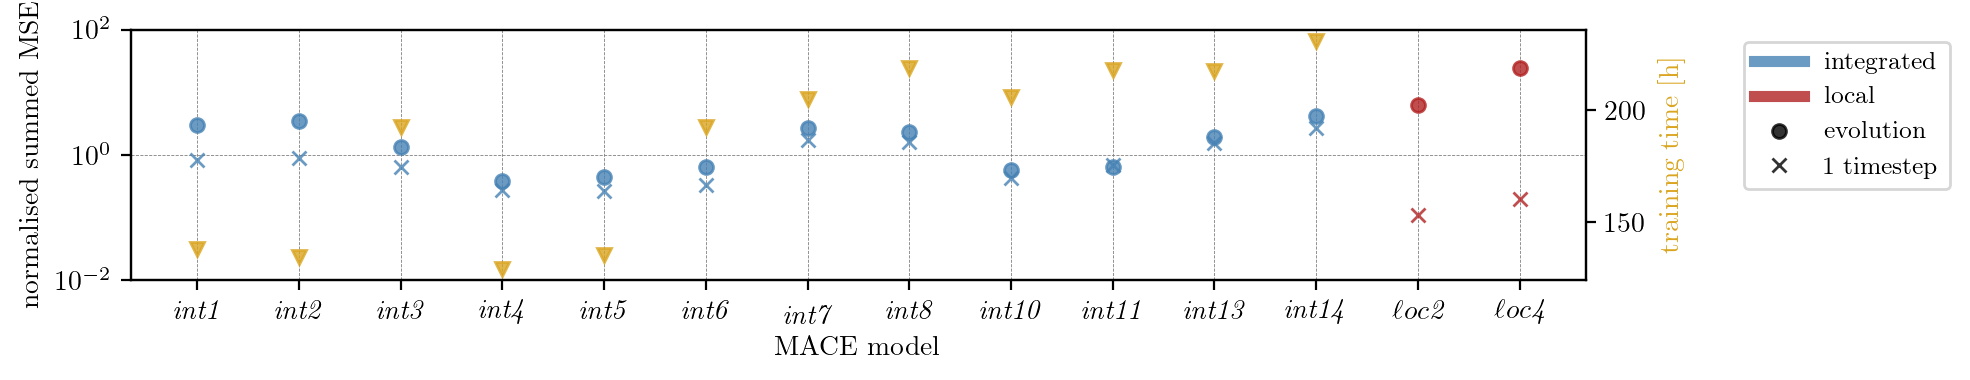

In [143]:
## INTEGRATED MODELS MODELS SUMMED MSE

idx1 = ['1','2','3', '4', '5','6']
idx2 = ['7','8','10','11']
idx3 = ['13', '14']
idx = []
outloc  = '/STER/silkem/MACE/models/CSE_0D/'

x = np.linspace(1,22,22)

fig = plt.figure(figsize = (10,2))
ax1 = fig.add_subplot((111))
ax2 = ax1.twinx()

lw = 0.5
handles = list()
losses_evol = list()
losses_step = list()    
dirs = list()
train_times = list()    # in hours

# ax1.set_title('Runs:64042')

for i in range(len(idx1)):
    dirname = '20240122_104049_64042_'+idx1[i]
    dirs.append(dirname)
    idx.append(idx1[i])
    testloss_evol = np.load(outloc+dirname+'/testloss_evol_3002.npy')
    testloss_step = np.load(outloc+dirname+'/testloss_step_3002.npy')
    print(testloss_evol, testloss_step)
    losses_evol.append(float(testloss_evol))
    losses_step.append(float(testloss_step))
    meta = utils.load_meta(outloc, dirname)
    train_times.append(meta['train_time_h'])


for i in range(len(idx2)):
    dirname = '20240122_104133_64048_'+idx2[i]
    dirs.append(dirname)
    idx.append(idx2[i])
    testloss_evol = np.load(outloc+dirname+'/testloss_evol_3002.npy')
    testloss_step = np.load(outloc+dirname+'/testloss_step_3002.npy')
    print(testloss_evol, testloss_step)
    losses_evol.append(float(testloss_evol))
    losses_step.append(float(testloss_step))
    meta = utils.load_meta(outloc, dirname)
    train_times.append(meta['train_time_h'])

for i in range(len(idx3)):
    dirname = '20240122_104150_64054_'+idx3[i]
    dirs.append(dirname)
    idx.append(idx3[i])
    testloss_evol = np.load(outloc+dirname+'/testloss_evol_3002.npy')
    testloss_step = np.load(outloc+dirname+'/testloss_step_3002.npy')
    print(testloss_evol, testloss_step)
    losses_evol.append(float(testloss_evol))
    losses_step.append(float(testloss_step))
    meta = utils.load_meta(outloc, dirname)
    train_times.append(meta['train_time_h'])


## comparison with local models
print('local')
losses_evol_local = list()
losses_step_local = list()   

dirname = '20240103_235005_58677_7'
dirs.append(dirname)
testloss_evol_local = np.load(outloc+dirname+'/testloss_evol_3002.npy')
testloss_step_local = np.load(outloc+dirname+'/testloss_step_3002.npy')
print(testloss_evol_local, testloss_step_local)
losses_evol_local.append(float(testloss_evol_local))
losses_step_local.append(float(testloss_step_local))

dirname = '20240103_151253_58677_3'
dirs.append(dirname)
testloss_evol_local = np.load(outloc+dirname+'/testloss_evol_3002.npy')
testloss_step_local = np.load(outloc+dirname+'/testloss_step_3002.npy')
print(testloss_evol_local, testloss_step_local)
losses_evol_local.append(float(testloss_evol_local))
losses_step_local.append(float(testloss_step_local))

losses_evol_local = np.array(losses_evol_local)/3002
losses_step_local = np.array(losses_step_local)/3002
losses_evol = np.array(losses_evol)/3002
losses_step = np.array(losses_step)/3002

# print(losses_evol)
ms = 10
a = 0.8
len_int = len(idx)
ax1.plot(losses_evol, '.',label='evolution', c='steelblue', ms=ms, alpha =a)
ax1.plot(losses_step, 'x',label='per time step', c='steelblue', ms =ms-5, alpha =a)
ax1.plot([len_int, len_int+1], losses_evol_local, '.',label='evolution local', c='firebrick', ms=ms, alpha =a)
ax1.plot([len_int, len_int+1], losses_step_local, 'x',label='per time step local', c='firebrick', ms =ms-5, alpha =a)
ax2.plot(train_times, 'v', color = 'goldenrod',label = 'training time', ms = ms-5, alpha = a)

ax1.set_ylabel('normalised summed MSE')



x = np.linspace(0,len(dirs)-1,len(dirs))
ax1.xaxis.set_major_locator(FixedLocator(x))

xticks = ['$\\emph{int'+idx[i]+'}$' for i in range(len(idx))]
xticks.append('$\\ell oc$\\emph{2}')
xticks.append('$\\ell oc$\\emph{4}')
ax1.set_xticklabels(xticks)
ax1.set_xlabel('MACE model')
ax2.set_ylabel('training time [h]', color = 'goldenrod')

ax1.grid(True, linestyle='--', linewidth=0.3, color='gray')

ax1.set_ylim(10**-2,10**2)
ax1.set_yscale('log')

lw = 4
l_intgr = mlines.Line2D([],[], color = 'steelblue', ls = '-' , label='integrated',lw = lw, alpha = a)
l_local = mlines.Line2D([],[], color = 'firebrick', ls = '-' , label='local',lw =lw, alpha = a)
l_evol = mlines.Line2D([],[], color = 'k', ls = 'none' , marker = '.', label='evolution',ms =ms, alpha = a)
l_step = mlines.Line2D([],[], color = 'k', ls = 'none' , marker = 'x', label='1 timestep',ms =ms-5, alpha = a)
    
handles = [l_intgr, l_local, l_evol, l_step]
plt.legend(handles = handles, fontsize = 9, loc='upper left', bbox_to_anchor=(1.1, 1))

plt.tight_layout()
plt.savefig('summed_MSE_comparison.png', dpi = 300)

plt.show()


________20240106_102404_58729_0_______________________________________________


The model has 285476 trainable parameters
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v2-5_T_eps/models/model_2022-12-26h13-44-39/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.011622190475463867

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 161.26it/s]


Solving time [s]: 0.0072405338287353516
Total   time [s]: 0.8343155384063721

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot2e-6_v22-5_T_eps/models/model_2023-01-03h08-20-35/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.011097908020019531

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 142.14it/s]


Solving time [s]: 0.0064241886138916016
Total   time [s]: 0.9465723037719727

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210521_gridC_Mdot5e-5_v25_T_eps/models/model_2022-12-25h13-41-58/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.010103225708007812

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 140.04it/s]


Solving time [s]: 0.006805419921875
Total   time [s]: 0.9601571559906006

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot5e-7_v12-5_T_eps/models/model_2022-12-27h12-11-38/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009767532348632812

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 154.74it/s]


Solving time [s]: 0.0076141357421875
Total   time [s]: 0.8713662624359131

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-7_v12-5_T_eps/models/model_2022-12-27h14-50-27/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009228944778442383

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 146.56it/s]


Solving time [s]: 0.00586247444152832
Total   time [s]: 0.9161241054534912

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-8_v5_T_eps/models/model_2022-12-27h16-58-00/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009364604949951172

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 158.67it/s]


Solving time [s]: 0.005987644195556641
Total   time [s]: 0.84722900390625

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v22-5_T_eps/models/model_2022-12-27h18-22-11/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.0075397491455078125

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 164.80it/s]


Solving time [s]: 0.005299091339111328
Total   time [s]: 0.8151874542236328

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v17-5_T_eps/models/model_2023-01-16h16-23-48/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.0082244873046875

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 157.46it/s]


Solving time [s]: 0.005273342132568359
Total   time [s]: 0.5107388496398926

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot1e-5_v20_T_eps/models/model_2022-12-27h13-58-11/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.007756948471069336

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 148.02it/s]


Solving time [s]: 0.005990028381347656
Total   time [s]: 0.9067080020904541

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-6_v20_T_eps/models/model_2022-12-28h20-18-19/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.008855342864990234

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 157.66it/s]


Solving time [s]: 0.006986379623413086
Total   time [s]: 0.8537719249725342

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-8_v2-5_T_eps/models/model_2022-12-26h16-47-56/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009280681610107422

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 142.69it/s]


Solving time [s]: 0.008662939071655273
Total   time [s]: 0.9470562934875488

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-6_v15_T_eps/models/model_2022-12-24h10-24-32/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.008917570114135742

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 145.58it/s]


Solving time [s]: 0.00959014892578125
Total   time [s]: 0.9238555431365967

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot5e-7_v17-5_T_eps/models/model_2022-12-28h19-48-29/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.007888555526733398

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 150.78it/s]


Solving time [s]: 0.006275177001953125
Total   time [s]: 0.8899247646331787

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210518_gridC_Mdot1e-8_v2-5_T_eps/models/model_2022-12-24h23-55-19/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009031057357788086

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 141.22it/s]


Solving time [s]: 0.007073879241943359
Total   time [s]: 0.5697050094604492

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v17-5_T_eps/models/model_2023-01-16h17-27-07/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.00985574722290039

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 153.97it/s]


Solving time [s]: 0.005517005920410156
Total   time [s]: 0.5217359066009521

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210518_gridC_Mdot1e-8_v2-5_T_eps/models/model_2022-12-24h22-02-20/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.00845193862915039

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 149.61it/s]


Solving time [s]: 0.0066454410552978516
Total   time [s]: 0.5360100269317627

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v15_T_eps/models/model_2022-12-23h16-53-13/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009722232818603516

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 153.99it/s]


Solving time [s]: 0.0063550472259521484
Total   time [s]: 0.8721022605895996

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-5_v17-5_T_eps/models/model_2022-12-24h16-45-04/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.008762121200561523

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 157.20it/s]


Solving time [s]: 0.006688833236694336
Total   time [s]: 0.8607444763183594

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-5_v17-5_T_eps/models/model_2022-12-24h15-53-59/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009500980377197266

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 157.66it/s]


Solving time [s]: 0.0066874027252197266
Total   time [s]: 0.8523614406585693

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-8_v5_T_eps/models/model_2022-12-25h09-31-15/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.010126113891601562

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 141.72it/s]


Solving time [s]: 0.006844758987426758
Total   time [s]: 0.9478411674499512

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-7_v10_T_eps/models/model_2022-12-24h10-24-59/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.008568525314331055

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 168.98it/s]


Solving time [s]: 0.005635499954223633
Total   time [s]: 0.7953972816467285

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v7-5_T_eps/models/model_2022-12-25h04-46-08/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.008347272872924805

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 176.35it/s]


Solving time [s]: 0.005263328552246094
Total   time [s]: 0.762892484664917

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------


________20240106_102404_58729_1_______________________________________________


The model has 289508 trainable parameters
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v2-5_T_eps/models/model_2022-12-26h13-44-39/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.008138656616210938

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 152.91it/s]


Solving time [s]: 0.006570100784301758
Total   time [s]: 0.8778717517852783

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot2e-6_v22-5_T_eps/models/model_2023-01-03h08-20-35/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.011789560317993164

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 141.51it/s]


Solving time [s]: 0.0073223114013671875
Total   time [s]: 0.9500448703765869

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210521_gridC_Mdot5e-5_v25_T_eps/models/model_2022-12-25h13-41-58/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.00981903076171875

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 160.27it/s]


Solving time [s]: 0.006773710250854492
Total   time [s]: 0.8393490314483643

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot5e-7_v12-5_T_eps/models/model_2022-12-27h12-11-38/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009545087814331055

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 141.48it/s]


Solving time [s]: 0.006021022796630859
Total   time [s]: 0.9493954181671143

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-7_v12-5_T_eps/models/model_2022-12-27h14-50-27/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009667396545410156

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 140.63it/s]


Solving time [s]: 0.006458282470703125
Total   time [s]: 0.9557695388793945

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-8_v5_T_eps/models/model_2022-12-27h16-58-00/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.010491371154785156

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 146.98it/s]


Solving time [s]: 0.006558656692504883
Total   time [s]: 0.9153029918670654

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v22-5_T_eps/models/model_2022-12-27h18-22-11/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.010307073593139648

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 147.17it/s]


Solving time [s]: 0.007017374038696289
Total   time [s]: 0.9135787487030029

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v17-5_T_eps/models/model_2023-01-16h16-23-48/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.008884668350219727

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 153.39it/s]


Solving time [s]: 0.006802558898925781
Total   time [s]: 0.5246398448944092

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot1e-5_v20_T_eps/models/model_2022-12-27h13-58-11/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009571552276611328

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 143.89it/s]


Solving time [s]: 0.007129192352294922
Total   time [s]: 0.9347898960113525

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-6_v20_T_eps/models/model_2022-12-28h20-18-19/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009807825088500977

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 152.76it/s]


Solving time [s]: 0.006353616714477539
Total   time [s]: 0.8805332183837891

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-8_v2-5_T_eps/models/model_2022-12-26h16-47-56/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.008695125579833984

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 155.44it/s]


Solving time [s]: 0.00664067268371582
Total   time [s]: 0.8645491600036621

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-6_v15_T_eps/models/model_2022-12-24h10-24-32/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.008457660675048828

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 156.82it/s]


Solving time [s]: 0.006793975830078125
Total   time [s]: 0.8565287590026855

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot5e-7_v17-5_T_eps/models/model_2022-12-28h19-48-29/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.011588573455810547

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 144.38it/s]


Solving time [s]: 0.00534510612487793
Total   time [s]: 0.9316864013671875

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210518_gridC_Mdot1e-8_v2-5_T_eps/models/model_2022-12-24h23-55-19/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009250640869140625

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 143.42it/s]


Solving time [s]: 0.008651971817016602
Total   time [s]: 0.5613656044006348

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v17-5_T_eps/models/model_2023-01-16h17-27-07/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009533882141113281

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 104.32it/s]


Solving time [s]: 0.006807565689086914
Total   time [s]: 0.7681927680969238

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210518_gridC_Mdot1e-8_v2-5_T_eps/models/model_2022-12-24h22-02-20/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.011267900466918945

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 107.95it/s]


Solving time [s]: 0.00809788703918457
Total   time [s]: 0.743948221206665

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v15_T_eps/models/model_2022-12-23h16-53-13/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.025814056396484375

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 88.41it/s] 


Solving time [s]: 0.010957479476928711
Total   time [s]: 1.5202956199645996

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-5_v17-5_T_eps/models/model_2022-12-24h16-45-04/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.011920928955078125

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 94.57it/s] 


Solving time [s]: 0.009668111801147461
Total   time [s]: 1.416104793548584

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-5_v17-5_T_eps/models/model_2022-12-24h15-53-59/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.014053583145141602

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 81.52it/s] 


Solving time [s]: 0.015879154205322266
Total   time [s]: 1.6468462944030762

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-8_v5_T_eps/models/model_2022-12-25h09-31-15/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.03290534019470215

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 118.27it/s]


Solving time [s]: 0.006582975387573242
Total   time [s]: 1.139042615890503

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-7_v10_T_eps/models/model_2022-12-24h10-24-59/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009607553482055664

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 133.24it/s]


Solving time [s]: 0.006706714630126953
Total   time [s]: 1.0078682899475098

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v7-5_T_eps/models/model_2022-12-25h04-46-08/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.00980377197265625

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 132.15it/s]


Solving time [s]: 0.006775856018066406
Total   time [s]: 1.0161089897155762

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------


________20240106_102404_58729_2_______________________________________________


The model has 284692 trainable parameters
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v2-5_T_eps/models/model_2022-12-26h13-44-39/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.007986783981323242

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 118.92it/s]


Solving time [s]: 0.007465362548828125
Total   time [s]: 1.1271295547485352

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot2e-6_v22-5_T_eps/models/model_2023-01-03h08-20-35/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.011893987655639648

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 99.25it/s] 


Solving time [s]: 0.00845026969909668
Total   time [s]: 1.3547275066375732

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210521_gridC_Mdot5e-5_v25_T_eps/models/model_2022-12-25h13-41-58/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.012533426284790039

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 132.26it/s]


Solving time [s]: 0.005741596221923828
Total   time [s]: 1.0156567096710205

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot5e-7_v12-5_T_eps/models/model_2022-12-27h12-11-38/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009398221969604492

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 150.04it/s]


Solving time [s]: 0.006903648376464844
Total   time [s]: 0.8964805603027344

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-7_v12-5_T_eps/models/model_2022-12-27h14-50-27/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009238719940185547

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 151.68it/s]


Solving time [s]: 0.006056070327758789
Total   time [s]: 0.8864719867706299

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-8_v5_T_eps/models/model_2022-12-27h16-58-00/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.00862884521484375

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 113.33it/s]


Solving time [s]: 0.009963274002075195
Total   time [s]: 1.183349370956421

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v22-5_T_eps/models/model_2022-12-27h18-22-11/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.036550045013427734

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 94.59it/s] 


Solving time [s]: 0.010701656341552734
Total   time [s]: 1.4197096824645996

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v17-5_T_eps/models/model_2023-01-16h16-23-48/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009621381759643555

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 115.86it/s]


Solving time [s]: 0.010267972946166992
Total   time [s]: 0.6929452419281006

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot1e-5_v20_T_eps/models/model_2022-12-27h13-58-11/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.012079000473022461

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 149.19it/s]


Solving time [s]: 0.0058252811431884766
Total   time [s]: 0.9036819934844971

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-6_v20_T_eps/models/model_2022-12-28h20-18-19/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.010222673416137695

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 156.10it/s]


Solving time [s]: 0.006174325942993164
Total   time [s]: 0.8622024059295654

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-8_v2-5_T_eps/models/model_2022-12-26h16-47-56/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009440422058105469

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 158.14it/s]


Solving time [s]: 0.005656003952026367
Total   time [s]: 0.8505120277404785

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-6_v15_T_eps/models/model_2022-12-24h10-24-32/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.008120298385620117

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 143.90it/s]


Solving time [s]: 0.007083892822265625
Total   time [s]: 0.9340555667877197

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot5e-7_v17-5_T_eps/models/model_2022-12-28h19-48-29/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009778022766113281

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 148.03it/s]


Solving time [s]: 0.006744861602783203
Total   time [s]: 0.9087786674499512

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210518_gridC_Mdot1e-8_v2-5_T_eps/models/model_2022-12-24h23-55-19/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.008156538009643555

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 144.05it/s]


Solving time [s]: 0.006737709045410156
Total   time [s]: 0.5581905841827393

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v17-5_T_eps/models/model_2023-01-16h17-27-07/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.008704662322998047

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 138.24it/s]


Solving time [s]: 0.00769805908203125
Total   time [s]: 0.5822625160217285

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210518_gridC_Mdot1e-8_v2-5_T_eps/models/model_2022-12-24h22-02-20/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009644508361816406

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 125.95it/s]


Solving time [s]: 0.007930278778076172
Total   time [s]: 0.6381518840789795

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v15_T_eps/models/model_2022-12-23h16-53-13/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.011128425598144531

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 130.98it/s]


Solving time [s]: 0.007396697998046875
Total   time [s]: 1.0457754135131836

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-5_v17-5_T_eps/models/model_2022-12-24h16-45-04/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009889841079711914

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 147.06it/s]


Solving time [s]: 0.00633692741394043
Total   time [s]: 0.914332389831543

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-5_v17-5_T_eps/models/model_2022-12-24h15-53-59/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.00847625732421875

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 136.71it/s]


Solving time [s]: 0.00764918327331543
Total   time [s]: 0.9829912185668945

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-8_v5_T_eps/models/model_2022-12-25h09-31-15/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.011337757110595703

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 136.31it/s]


Solving time [s]: 0.008585691452026367
Total   time [s]: 0.987548828125

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-7_v10_T_eps/models/model_2022-12-24h10-24-59/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.01061701774597168

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 120.59it/s]


Solving time [s]: 0.006699085235595703
Total   time [s]: 1.1123812198638916

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v7-5_T_eps/models/model_2022-12-25h04-46-08/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.011009931564331055

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 127.73it/s]


Solving time [s]: 0.00780940055847168
Total   time [s]: 1.0521183013916016

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------


________20240106_102404_58729_3_______________________________________________


The model has 321028 trainable parameters
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v2-5_T_eps/models/model_2022-12-26h13-44-39/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.030478715896606445

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 123.85it/s]


Solving time [s]: 0.007591962814331055
Total   time [s]: 1.086026668548584

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot2e-6_v22-5_T_eps/models/model_2023-01-03h08-20-35/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.027755260467529297

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 133.41it/s]


Solving time [s]: 0.010376214981079102
Total   time [s]: 1.0103418827056885

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210521_gridC_Mdot5e-5_v25_T_eps/models/model_2022-12-25h13-41-58/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.03205108642578125

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 126.92it/s]


Solving time [s]: 0.008298873901367188
Total   time [s]: 1.0603835582733154

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot5e-7_v12-5_T_eps/models/model_2022-12-27h12-11-38/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.02986311912536621

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 124.87it/s]


Solving time [s]: 0.008617639541625977
Total   time [s]: 1.0765173435211182

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-7_v12-5_T_eps/models/model_2022-12-27h14-50-27/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.02890777587890625

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 121.44it/s]


Solving time [s]: 0.007576942443847656
Total   time [s]: 1.1062335968017578

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-8_v5_T_eps/models/model_2022-12-27h16-58-00/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.02562880516052246

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 112.94it/s]


Solving time [s]: 0.009525537490844727
Total   time [s]: 1.1880714893341064

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v22-5_T_eps/models/model_2022-12-27h18-22-11/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.029770851135253906

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 120.44it/s]


Solving time [s]: 0.008527040481567383
Total   time [s]: 1.1169078350067139

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v17-5_T_eps/models/model_2023-01-16h16-23-48/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.01666879653930664

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 122.64it/s]


Solving time [s]: 0.007804393768310547
Total   time [s]: 0.6549484729766846

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot1e-5_v20_T_eps/models/model_2022-12-27h13-58-11/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.02669358253479004

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 131.35it/s]


Solving time [s]: 0.009217500686645508
Total   time [s]: 1.0566201210021973

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-6_v20_T_eps/models/model_2022-12-28h20-18-19/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.029856204986572266

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 135.18it/s]


Solving time [s]: 0.00706934928894043
Total   time [s]: 0.9947428703308105

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-8_v2-5_T_eps/models/model_2022-12-26h16-47-56/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.028757572174072266

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 133.77it/s]


Solving time [s]: 0.008138656616210938
Total   time [s]: 1.0055394172668457

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-6_v15_T_eps/models/model_2022-12-24h10-24-32/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.022919893264770508

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 133.36it/s]


Solving time [s]: 0.008170843124389648
Total   time [s]: 1.0076570510864258

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot5e-7_v17-5_T_eps/models/model_2022-12-28h19-48-29/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.02834939956665039

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 123.05it/s]


Solving time [s]: 0.008143186569213867
Total   time [s]: 1.0916619300842285

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210518_gridC_Mdot1e-8_v2-5_T_eps/models/model_2022-12-24h23-55-19/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.020676136016845703

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 130.84it/s]


Solving time [s]: 0.006219148635864258
Total   time [s]: 0.6146471500396729

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v17-5_T_eps/models/model_2023-01-16h17-27-07/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.019634246826171875

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 136.99it/s]


Solving time [s]: 0.006517887115478516
Total   time [s]: 0.5869152545928955

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210518_gridC_Mdot1e-8_v2-5_T_eps/models/model_2022-12-24h22-02-20/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.021241188049316406

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 130.38it/s]


Solving time [s]: 0.00630640983581543
Total   time [s]: 0.6172223091125488

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v15_T_eps/models/model_2022-12-23h16-53-13/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.025313138961791992

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 133.62it/s]


Solving time [s]: 0.007880449295043945
Total   time [s]: 1.0186078548431396

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-5_v17-5_T_eps/models/model_2022-12-24h16-45-04/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.029282808303833008

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 130.35it/s]


Solving time [s]: 0.009122371673583984
Total   time [s]: 1.0314559936523438

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-5_v17-5_T_eps/models/model_2022-12-24h15-53-59/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.028437376022338867

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 137.91it/s]


Solving time [s]: 0.008177518844604492
Total   time [s]: 0.9752252101898193

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-8_v5_T_eps/models/model_2022-12-25h09-31-15/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.021427631378173828

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 130.60it/s]


Solving time [s]: 0.00732421875
Total   time [s]: 1.0286767482757568

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-7_v10_T_eps/models/model_2022-12-24h10-24-59/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.033330678939819336

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 109.57it/s]


Solving time [s]: 0.009834527969360352
Total   time [s]: 1.2249815464019775

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v7-5_T_eps/models/model_2022-12-25h04-46-08/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.033130645751953125

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 114.64it/s]


Solving time [s]: 0.007237434387207031
Total   time [s]: 1.1736981868743896

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------


________20240106_102404_58729_4_______________________________________________


The model has 289508 trainable parameters
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v2-5_T_eps/models/model_2022-12-26h13-44-39/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.010344743728637695

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 138.87it/s]


Solving time [s]: 0.006029605865478516
Total   time [s]: 0.9670262336730957

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot2e-6_v22-5_T_eps/models/model_2023-01-03h08-20-35/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009287834167480469

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 113.36it/s]


Solving time [s]: 0.008630037307739258
Total   time [s]: 1.1826295852661133

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210521_gridC_Mdot5e-5_v25_T_eps/models/model_2022-12-25h13-41-58/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.012669086456298828

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 103.15it/s]


Solving time [s]: 0.00799560546875
Total   time [s]: 1.3012175559997559

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot5e-7_v12-5_T_eps/models/model_2022-12-27h12-11-38/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.04945969581604004

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 121.53it/s]


Solving time [s]: 0.007773160934448242
Total   time [s]: 1.1407091617584229

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-7_v12-5_T_eps/models/model_2022-12-27h14-50-27/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.010601043701171875

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 130.41it/s]


Solving time [s]: 0.007508516311645508
Total   time [s]: 1.0314114093780518

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-8_v5_T_eps/models/model_2022-12-27h16-58-00/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.012909412384033203

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 128.56it/s]


Solving time [s]: 0.006913900375366211
Total   time [s]: 1.0476322174072266

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v22-5_T_eps/models/model_2022-12-27h18-22-11/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009344816207885742

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 139.29it/s]


Solving time [s]: 0.007052183151245117
Total   time [s]: 0.9641518592834473

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v17-5_T_eps/models/model_2023-01-16h16-23-48/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.007007598876953125

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 150.87it/s]


Solving time [s]: 0.006882667541503906
Total   time [s]: 0.5323548316955566

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot1e-5_v20_T_eps/models/model_2022-12-27h13-58-11/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009746074676513672

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 151.75it/s]


Solving time [s]: 0.006625175476074219
Total   time [s]: 0.8866226673126221

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-6_v20_T_eps/models/model_2022-12-28h20-18-19/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009835243225097656

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 144.39it/s]


Solving time [s]: 0.006150245666503906
Total   time [s]: 0.9299166202545166

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-8_v2-5_T_eps/models/model_2022-12-26h16-47-56/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.010159969329833984

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 152.75it/s]


Solving time [s]: 0.005601167678833008
Total   time [s]: 0.8804202079772949

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-6_v15_T_eps/models/model_2022-12-24h10-24-32/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.011793136596679688

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 159.43it/s]


Solving time [s]: 0.007454633712768555
Total   time [s]: 0.8442957401275635

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot5e-7_v17-5_T_eps/models/model_2022-12-28h19-48-29/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009408235549926758

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 157.70it/s]


Solving time [s]: 0.005949497222900391
Total   time [s]: 0.8526878356933594

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210518_gridC_Mdot1e-8_v2-5_T_eps/models/model_2022-12-24h23-55-19/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.010438203811645508

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 123.30it/s]


Solving time [s]: 0.008589506149291992
Total   time [s]: 0.6506431102752686

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v17-5_T_eps/models/model_2023-01-16h17-27-07/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.007880210876464844

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 152.85it/s]


Solving time [s]: 0.006566524505615234
Total   time [s]: 0.5262610912322998

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210518_gridC_Mdot1e-8_v2-5_T_eps/models/model_2022-12-24h22-02-20/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.007814168930053711

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 146.73it/s]


Solving time [s]: 0.007020711898803711
Total   time [s]: 0.5470328330993652

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v15_T_eps/models/model_2022-12-23h16-53-13/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.00875401496887207

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 147.92it/s]


Solving time [s]: 0.0071604251861572266
Total   time [s]: 0.9080629348754883

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-5_v17-5_T_eps/models/model_2022-12-24h16-45-04/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.010667085647583008

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 140.18it/s]


Solving time [s]: 0.007604360580444336
Total   time [s]: 0.9592111110687256

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-5_v17-5_T_eps/models/model_2022-12-24h15-53-59/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.01005864143371582

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 133.56it/s]


Solving time [s]: 0.00994110107421875
Total   time [s]: 1.006239652633667

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-8_v5_T_eps/models/model_2022-12-25h09-31-15/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.01005697250366211

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 140.52it/s]


Solving time [s]: 0.007101774215698242
Total   time [s]: 0.956341028213501

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-7_v10_T_eps/models/model_2022-12-24h10-24-59/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.010616779327392578

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 133.59it/s]


Solving time [s]: 0.008019685745239258
Total   time [s]: 1.0059988498687744

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v7-5_T_eps/models/model_2022-12-25h04-46-08/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.011204957962036133

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 132.59it/s]


Solving time [s]: 0.0070378780364990234
Total   time [s]: 1.0141243934631348

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------


________20240106_102404_58729_5_______________________________________________


The model has 284692 trainable parameters
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v2-5_T_eps/models/model_2022-12-26h13-44-39/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009351968765258789

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 131.54it/s]


Solving time [s]: 0.007131814956665039
Total   time [s]: 1.0213689804077148

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot2e-6_v22-5_T_eps/models/model_2023-01-03h08-20-35/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.01159977912902832

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 106.07it/s]


Solving time [s]: 0.008599281311035156
Total   time [s]: 1.2664110660552979

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210521_gridC_Mdot5e-5_v25_T_eps/models/model_2022-12-25h13-41-58/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.010983467102050781

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 106.01it/s]


Solving time [s]: 0.009526729583740234
Total   time [s]: 1.266023874282837

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot5e-7_v12-5_T_eps/models/model_2022-12-27h12-11-38/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.011584281921386719

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 142.34it/s]


Solving time [s]: 0.005964756011962891
Total   time [s]: 0.9459197521209717

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-7_v12-5_T_eps/models/model_2022-12-27h14-50-27/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.01068115234375

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 153.38it/s]


Solving time [s]: 0.006535053253173828
Total   time [s]: 0.8849358558654785

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-8_v5_T_eps/models/model_2022-12-27h16-58-00/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009875297546386719

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 155.20it/s]


Solving time [s]: 0.007489919662475586
Total   time [s]: 0.8672337532043457

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v22-5_T_eps/models/model_2022-12-27h18-22-11/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009748220443725586

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 153.71it/s]


Solving time [s]: 0.005630970001220703
Total   time [s]: 0.8748879432678223

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v17-5_T_eps/models/model_2023-01-16h16-23-48/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009029865264892578

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 153.89it/s]


Solving time [s]: 0.005280017852783203
Total   time [s]: 0.5234031677246094

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot1e-5_v20_T_eps/models/model_2022-12-27h13-58-11/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.007843017578125

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 155.71it/s]


Solving time [s]: 0.006692647933959961
Total   time [s]: 0.8632023334503174

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-6_v20_T_eps/models/model_2022-12-28h20-18-19/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.022893905639648438

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 145.60it/s]


Solving time [s]: 0.006892681121826172
Total   time [s]: 0.9355571269989014

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-8_v2-5_T_eps/models/model_2022-12-26h16-47-56/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009181499481201172

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 145.74it/s]


Solving time [s]: 0.006062030792236328
Total   time [s]: 0.9226059913635254

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-6_v15_T_eps/models/model_2022-12-24h10-24-32/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.010509014129638672

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 136.67it/s]


Solving time [s]: 0.007055997848510742
Total   time [s]: 0.9832489490509033

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot5e-7_v17-5_T_eps/models/model_2022-12-28h19-48-29/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009025096893310547

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 144.88it/s]


Solving time [s]: 0.0067195892333984375
Total   time [s]: 0.927147626876831

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210518_gridC_Mdot1e-8_v2-5_T_eps/models/model_2022-12-24h23-55-19/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.008312463760375977

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 144.46it/s]


Solving time [s]: 0.006360054016113281
Total   time [s]: 0.5559647083282471

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v17-5_T_eps/models/model_2023-01-16h17-27-07/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.00818181037902832

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 141.62it/s]


Solving time [s]: 0.006555080413818359
Total   time [s]: 0.569399356842041

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210518_gridC_Mdot1e-8_v2-5_T_eps/models/model_2022-12-24h22-02-20/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.0075550079345703125

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 148.56it/s]


Solving time [s]: 0.006770610809326172
Total   time [s]: 0.5424232482910156

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v15_T_eps/models/model_2022-12-23h16-53-13/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009510517120361328

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 151.38it/s]


Solving time [s]: 0.006842613220214844
Total   time [s]: 0.8885219097137451

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-5_v17-5_T_eps/models/model_2022-12-24h16-45-04/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.007984399795532227

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 140.93it/s]


Solving time [s]: 0.0069544315338134766
Total   time [s]: 0.9535403251647949

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-5_v17-5_T_eps/models/model_2022-12-24h15-53-59/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.0083160400390625

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 154.23it/s]


Solving time [s]: 0.007096052169799805
Total   time [s]: 0.8730418682098389

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-8_v5_T_eps/models/model_2022-12-25h09-31-15/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.008048057556152344

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 147.65it/s]


Solving time [s]: 0.008165836334228516
Total   time [s]: 0.9103846549987793

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-7_v10_T_eps/models/model_2022-12-24h10-24-59/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.010537147521972656

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 154.07it/s]


Solving time [s]: 0.008301734924316406
Total   time [s]: 0.8745932579040527

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v7-5_T_eps/models/model_2022-12-25h04-46-08/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.008063316345214844

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 143.09it/s]


Solving time [s]: 0.006788969039916992
Total   time [s]: 0.939922571182251

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------


________20240106_102404_58729_6_______________________________________________


The model has 285476 trainable parameters
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v2-5_T_eps/models/model_2022-12-26h13-44-39/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009437322616577148

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 161.64it/s]


Solving time [s]: 0.005427360534667969
Total   time [s]: 0.8333168029785156

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot2e-6_v22-5_T_eps/models/model_2023-01-03h08-20-35/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.008490562438964844

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 152.20it/s]


Solving time [s]: 0.007703542709350586
Total   time [s]: 0.8827214241027832

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210521_gridC_Mdot5e-5_v25_T_eps/models/model_2022-12-25h13-41-58/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009833812713623047

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 143.19it/s]


Solving time [s]: 0.0058057308197021484
Total   time [s]: 0.9383687973022461

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot5e-7_v12-5_T_eps/models/model_2022-12-27h12-11-38/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009750604629516602

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 137.02it/s]


Solving time [s]: 0.006466865539550781
Total   time [s]: 0.9807121753692627

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-7_v12-5_T_eps/models/model_2022-12-27h14-50-27/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009113788604736328

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 147.92it/s]


Solving time [s]: 0.006208658218383789
Total   time [s]: 0.9077634811401367

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-8_v5_T_eps/models/model_2022-12-27h16-58-00/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009264469146728516

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 156.33it/s]


Solving time [s]: 0.006237983703613281
Total   time [s]: 0.8598945140838623

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v22-5_T_eps/models/model_2022-12-27h18-22-11/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009554147720336914

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 152.34it/s]


Solving time [s]: 0.006693124771118164
Total   time [s]: 0.8820910453796387

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v17-5_T_eps/models/model_2023-01-16h16-23-48/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.010681390762329102

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 126.58it/s]


Solving time [s]: 0.006661653518676758
Total   time [s]: 0.6352059841156006

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot1e-5_v20_T_eps/models/model_2022-12-27h13-58-11/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.0098876953125

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 149.64it/s]


Solving time [s]: 0.0068438053131103516
Total   time [s]: 0.8986473083496094

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-6_v20_T_eps/models/model_2022-12-28h20-18-19/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.00952601432800293

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 152.80it/s]


Solving time [s]: 0.00666499137878418
Total   time [s]: 0.8800394535064697

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-8_v2-5_T_eps/models/model_2022-12-26h16-47-56/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.00992584228515625

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 151.09it/s]


Solving time [s]: 0.0058133602142333984
Total   time [s]: 0.8897264003753662

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-6_v15_T_eps/models/model_2022-12-24h10-24-32/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009694576263427734

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 147.76it/s]


Solving time [s]: 0.008069515228271484
Total   time [s]: 0.9094879627227783

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot5e-7_v17-5_T_eps/models/model_2022-12-28h19-48-29/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.01060795783996582

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 151.97it/s]


Solving time [s]: 0.006724357604980469
Total   time [s]: 0.886594295501709

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210518_gridC_Mdot1e-8_v2-5_T_eps/models/model_2022-12-24h23-55-19/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.007723569869995117

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 139.35it/s]


Solving time [s]: 0.00603175163269043
Total   time [s]: 0.5756592750549316

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v17-5_T_eps/models/model_2023-01-16h17-27-07/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.00901937484741211

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 139.42it/s]


Solving time [s]: 0.006512880325317383
Total   time [s]: 0.5776875019073486

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210518_gridC_Mdot1e-8_v2-5_T_eps/models/model_2022-12-24h22-02-20/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.007754325866699219

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 149.46it/s]


Solving time [s]: 0.0071985721588134766
Total   time [s]: 0.537837028503418

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v15_T_eps/models/model_2022-12-23h16-53-13/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009553909301757812

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 153.37it/s]


Solving time [s]: 0.006471395492553711
Total   time [s]: 0.8789064884185791

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-5_v17-5_T_eps/models/model_2022-12-24h16-45-04/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009563684463500977

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 143.62it/s]


Solving time [s]: 0.006628274917602539
Total   time [s]: 0.9359080791473389

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-5_v17-5_T_eps/models/model_2022-12-24h15-53-59/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.01005697250366211

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 150.14it/s]


Solving time [s]: 0.007761716842651367
Total   time [s]: 0.8957653045654297

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-8_v5_T_eps/models/model_2022-12-25h09-31-15/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.010315656661987305

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 148.74it/s]


Solving time [s]: 0.008238554000854492
Total   time [s]: 0.9049985408782959

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-7_v10_T_eps/models/model_2022-12-24h10-24-59/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009963750839233398

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 145.32it/s]


Solving time [s]: 0.0060007572174072266
Total   time [s]: 0.9254276752471924

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v7-5_T_eps/models/model_2022-12-25h04-46-08/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.00782322883605957

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 142.50it/s]


Solving time [s]: 0.006277799606323242
Total   time [s]: 0.9428296089172363

>> Denormalising abundances...

>> Calculating & saving losses...
Done!
----------------------------------------



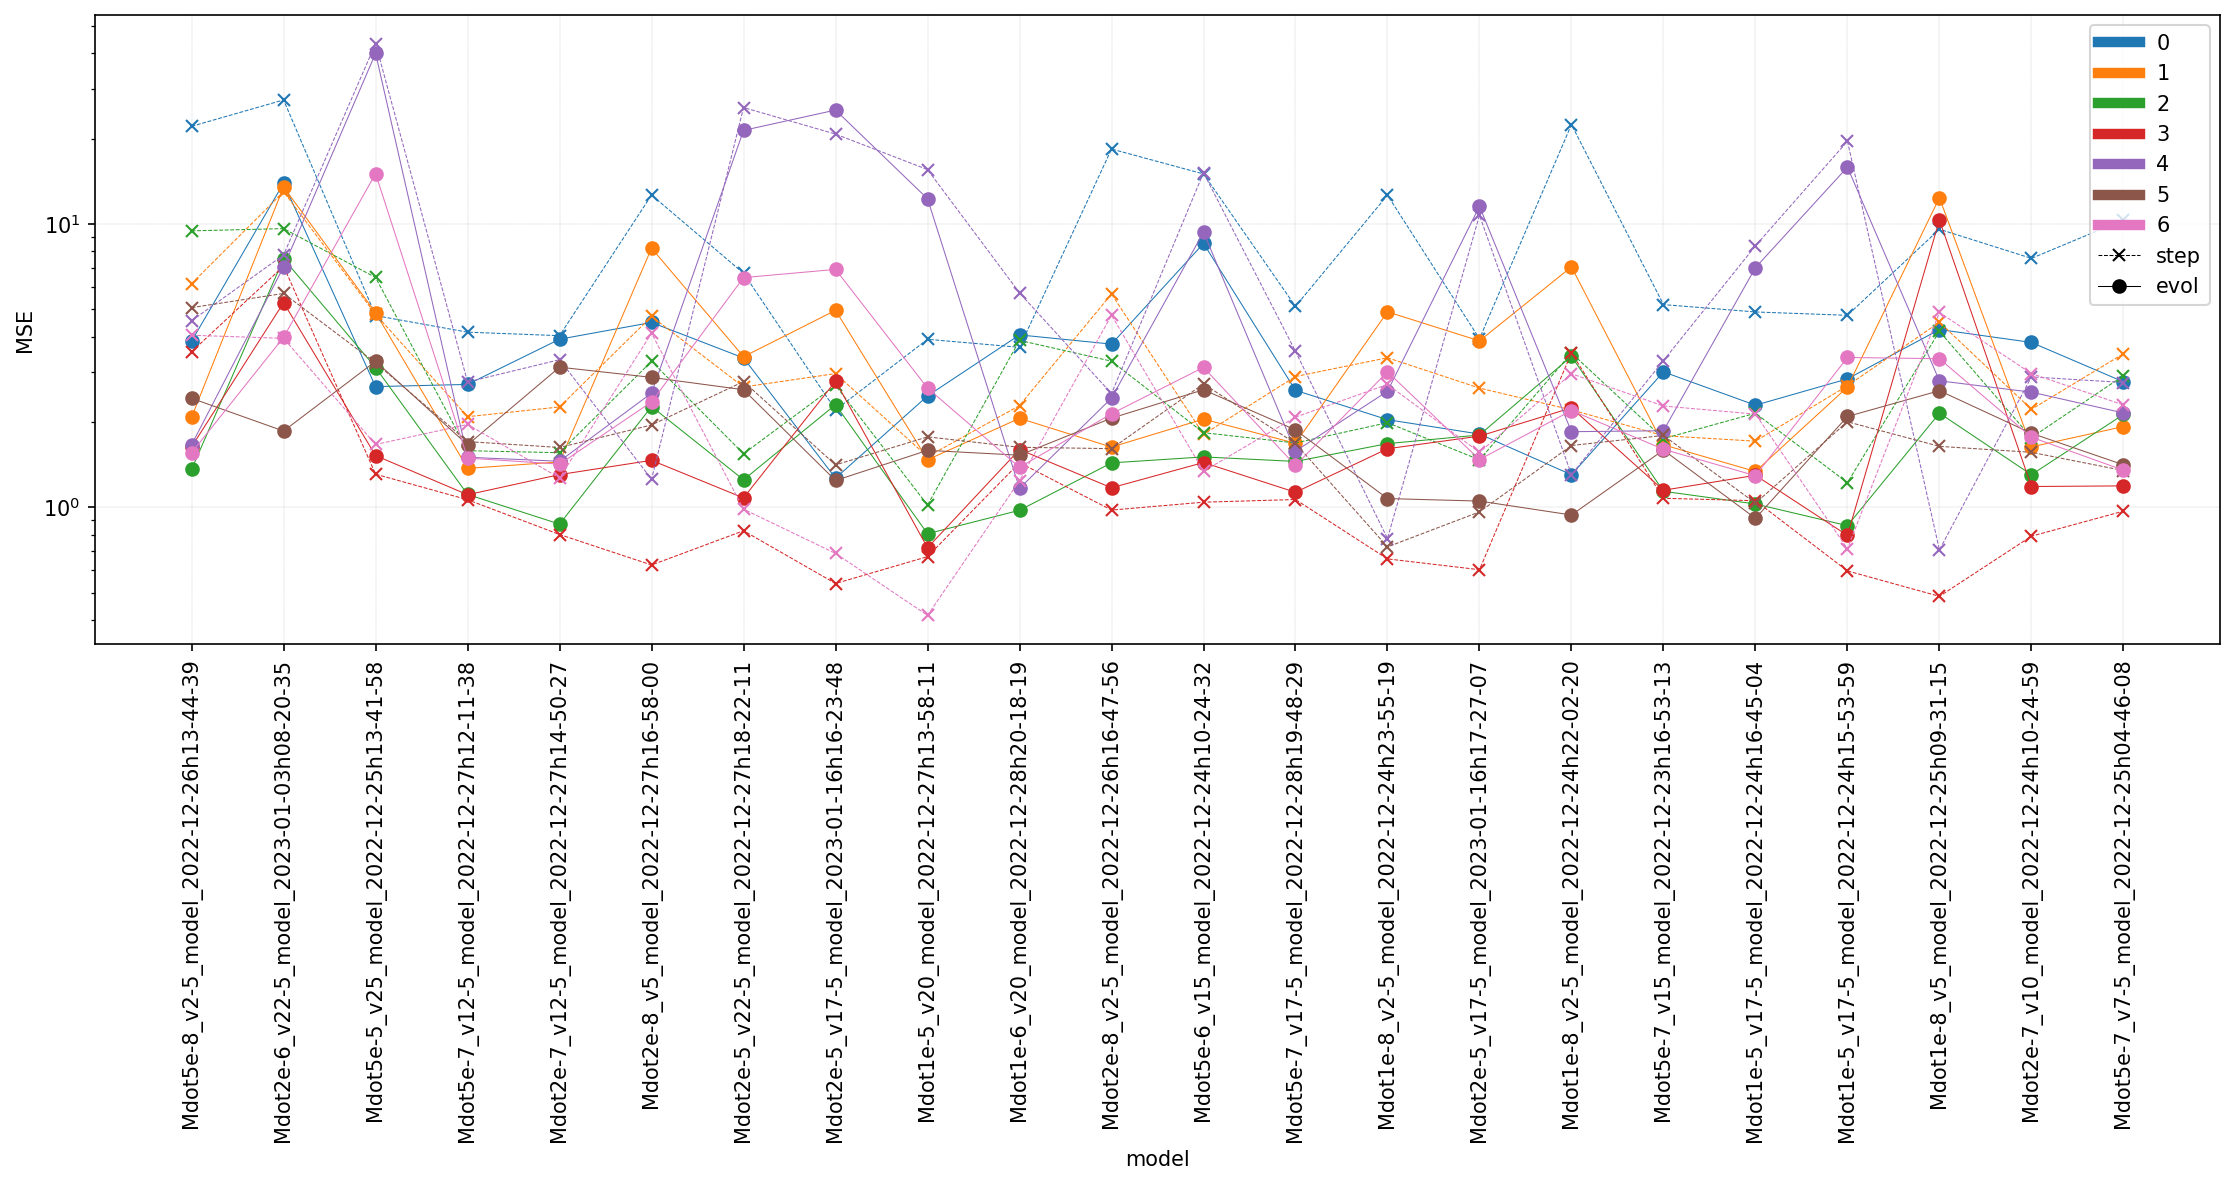

In [5]:
idx = ['0', '1', '2','3', '4', '5', '6']
# idx = ['4', '5', '6']
outloc  = '/STER/silkem/MACE/models/CSE_0D/'

x = np.linspace(1,22,22)

fig = plt.figure(figsize = (15,8))
ax1 = fig.add_subplot((111))
lw = 0.5
handles = list()

specs = ['CO', 'H2O', 'HCN', 'H2S','C2H2', 'OH', 'CN', 'HS', 'C2H', 'CH3C5NH+']

for i in range(len(idx)):
    dirname = '20240106_102404_58729_'+idx[i]
    print('\n________'+dirname+'_______________________________________________\n\n')

    meta_, model_, trainloss_, testloss_ = utils.load_all(outloc, dirname) # type: ignore
    plots_path = outloc+dirname+'/plots/'
    utils.makeOutputDir(plots_path)

    if not os.path.exists(outloc+dirname+"/testloss.json"):
        testloss = {}
        json_loss = json.dumps(testloss, indent=4)
        with open(outloc+dirname+"/testloss.json", "w") as outfile:
            outfile.write(json_loss)
    
    avg_step, std_step, sum_step, avg_evol, std_evol, sum_evol, mods = test_model(model_, specs = specs, plots_path = plots_path, plotting = False, save = True)
    
    line, = ax1.plot(x,sum_step,marker ='x', linestyle = '--', lw = lw)
    ax1.plot(x,sum_evol,marker ='o', linestyle = '-',color = line.get_color(),  lw = lw)
    leg = mlines.Line2D([],[], color = line.get_color(), ls = '-' , lw = 5, label = idx[i])
    handles.append(leg)

ax1.set_yscale('log')

ax1.set_xlabel('model', fontsize = 10)
ax1.set_ylabel('MSE', fontsize = 10)


ax1.xaxis.set_major_locator(FixedLocator(x))
ax1.set_xticklabels(mods, rotation=90, fontsize = 10)

ax1.grid(True, linestyle='--', linewidth=0.1, color='gray')

l_step = mlines.Line2D([],[], color = 'k', ls = '--' , marker = 'x', label='step', lw = lw)
l_evol = mlines.Line2D([],[], color = 'k', ls = '-' , marker = 'o', label='evol', lw = lw)

handles.append(l_step)
handles.append(l_evol)

plt.legend(handles = handles, fontsize = 10)

plt.tight_layout()
plt.savefig('test_mse.png')
plt.show()


________20240106_102404_58729_0_______________________________________________


/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-6_v12-5_T_eps/models/model_2022-12-23h11-00-25/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.021348953247070312

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 106.38it/s]


Solving time [s]: 0.009891033172607422
Total   time [s]: 1.2646324634552002

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-7_v15_T_eps/models/model_2022-12-28h14-46-56/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.011059045791625977

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 125.96it/s]


Solving time [s]: 0.008234024047851562
Total   time [s]: 1.0695688724517822

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot1e-5_v20_T_eps/models/model_2022-12-27h14-09-37/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.009040117263793945

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 135.08it/s]


Solving time [s]: 0.0077304840087890625
Total   time [s]: 0.9939556121826172

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v15_T_eps/models/model_2022-12-23h15-59-16/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.009662628173828125

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 136.78it/s]


Solving time [s]: 0.007391214370727539
Total   time [s]: 0.9822607040405273

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v22-5_T_eps/models/model_2022-12-27h18-35-08/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.010951757431030273

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 141.35it/s]


Solving time [s]: 0.006295204162597656
Total   time [s]: 0.951798677444458

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210525_gridC_Mdot1e-8_v25_T_eps/models/model_2022-12-27h02-09-43/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.009404420852661133

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 147.41it/s]


Solving time [s]: 0.005830287933349609
Total   time [s]: 0.9123010635375977

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-7_v7-5_T_eps/models/model_2022-12-23h15-01-36/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.009673357009887695

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 138.45it/s]


Solving time [s]: 0.008374452590942383
Total   time [s]: 0.9694414138793945

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v10_T_eps/models/model_2022-12-24h12-17-41/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.008979558944702148

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 137.64it/s]


Solving time [s]: 0.0070416927337646484
Total   time [s]: 0.9760293960571289

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot5e-6_v25_T_eps/models/model_2022-12-24h13-28-48/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.010596036911010742

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 146.97it/s]


Solving time [s]: 0.0074312686920166016
Total   time [s]: 0.9150137901306152

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v22-5_T_eps/models/model_2022-12-27h18-52-40/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.011319160461425781

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 119.64it/s]


Solving time [s]: 0.008426666259765625
Total   time [s]: 1.129117727279663

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-5_v17-5_T_eps/models/model_2022-12-24h15-53-14/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.011081218719482422

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 142.40it/s]


Solving time [s]: 0.006023406982421875
Total   time [s]: 0.9445538520812988

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v12-5_T_eps/models/model_2022-12-25h01-24-18/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.010158777236938477

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 145.08it/s]


Solving time [s]: 0.0062448978424072266
Total   time [s]: 0.9274871349334717

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-6_v17-5_T_eps/models/model_2023-01-03h15-17-26/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.008486032485961914

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 146.20it/s]


Solving time [s]: 0.00711512565612793
Total   time [s]: 0.9187054634094238

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot2e-5_v25_T_eps/models/model_2022-12-24h19-15-42/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.01062917709350586

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 136.71it/s]


Solving time [s]: 0.0071697235107421875
Total   time [s]: 0.9842767715454102

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot1e-5_v20_T_eps/models/model_2022-12-27h13-45-15/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.010213136672973633

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 149.20it/s]


Solving time [s]: 0.005239725112915039
Total   time [s]: 0.9017038345336914

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210525_gridC_Mdot1e-7_v2-5_T_eps/models/model_2022-12-24h21-18-39/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.009947538375854492

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 135.52it/s]


Solving time [s]: 0.007298946380615234
Total   time [s]: 0.5933506488800049

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-8_v7.5_T_eps/models/model_2022-12-25h14-40-51/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.009908914566040039

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 141.15it/s]


Solving time [s]: 0.007576704025268555
Total   time [s]: 0.9520950317382812

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210521_gridC_Mdot5e-5_v25_T_eps/models/model_2022-12-25h13-36-15/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.011816978454589844

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 123.50it/s]


Solving time [s]: 0.006383180618286133
Total   time [s]: 1.0885889530181885

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210525_gridC_Mdot1e-7_v2-5_T_eps/models/model_2022-12-24h21-14-55/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.009827375411987305

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 135.80it/s]


Solving time [s]: 0.00668787956237793
Total   time [s]: 0.5922625064849854

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot5e-6_v25_T_eps/models/model_2022-12-24h14-20-09/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.010976791381835938

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 142.47it/s]


Solving time [s]: 0.005943775177001953
Total   time [s]: 0.9446976184844971

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot2e-6_v22-5_T_eps/models/model_2022-12-27h04-05-05/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.010656118392944336

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 142.19it/s]


Solving time [s]: 0.007315874099731445
Total   time [s]: 0.945894718170166

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v5_T_eps/models/model_2022-12-25h10-59-57/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.009581327438354492

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 134.04it/s]


Solving time [s]: 0.007109165191650391
Total   time [s]: 1.001694917678833

>> Denormalising abundances...

________20240106_102404_58729_1_______________________________________________


/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-6_v12-5_T_eps/models/model_2022-12-23h11-00-25/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.011751174926757812

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 142.83it/s]


Solving time [s]: 0.005874156951904297
Total   time [s]: 0.9428186416625977

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-7_v15_T_eps/models/model_2022-12-28h14-46-56/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.011780977249145508

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 144.27it/s]


Solving time [s]: 0.006029367446899414
Total   time [s]: 0.9330599308013916

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot1e-5_v20_T_eps/models/model_2022-12-27h14-09-37/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.011657238006591797

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 148.15it/s]


Solving time [s]: 0.006128072738647461
Total   time [s]: 0.9082605838775635

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v15_T_eps/models/model_2022-12-23h15-59-16/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.01035928726196289

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 122.29it/s]


Solving time [s]: 0.006159782409667969
Total   time [s]: 1.0976967811584473

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v22-5_T_eps/models/model_2022-12-27h18-35-08/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.010816097259521484

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 150.52it/s]


Solving time [s]: 0.006793022155761719
Total   time [s]: 0.8929588794708252

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210525_gridC_Mdot1e-8_v25_T_eps/models/model_2022-12-27h02-09-43/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.009381771087646484

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 144.10it/s]


Solving time [s]: 0.00786280632019043
Total   time [s]: 0.933678388595581

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-7_v7-5_T_eps/models/model_2022-12-23h15-01-36/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.009284734725952148

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 143.92it/s]


Solving time [s]: 0.0072405338287353516
Total   time [s]: 0.9343662261962891

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v10_T_eps/models/model_2022-12-24h12-17-41/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.009582996368408203

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 132.58it/s]


Solving time [s]: 0.007359504699707031
Total   time [s]: 1.0128850936889648

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot5e-6_v25_T_eps/models/model_2022-12-24h13-28-48/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.011851787567138672

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 133.51it/s]


Solving time [s]: 0.007346391677856445
Total   time [s]: 1.0072546005249023

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v22-5_T_eps/models/model_2022-12-27h18-52-40/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.011027336120605469

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 135.35it/s]


Solving time [s]: 0.008624553680419922
Total   time [s]: 0.9935212135314941

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-5_v17-5_T_eps/models/model_2022-12-24h15-53-14/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.011497259140014648

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 135.94it/s]


Solving time [s]: 0.007171630859375
Total   time [s]: 0.9895424842834473

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v12-5_T_eps/models/model_2022-12-25h01-24-18/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.01154780387878418

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 131.55it/s]


Solving time [s]: 0.007237672805786133
Total   time [s]: 1.0218331813812256

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-6_v17-5_T_eps/models/model_2023-01-03h15-17-26/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.009934186935424805

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 146.67it/s]


Solving time [s]: 0.006978034973144531
Total   time [s]: 0.917407751083374

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot2e-5_v25_T_eps/models/model_2022-12-24h19-15-42/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.011377096176147461

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 143.12it/s]


Solving time [s]: 0.006142616271972656
Total   time [s]: 0.9400992393493652

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot1e-5_v20_T_eps/models/model_2022-12-27h13-45-15/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.011289596557617188

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 137.30it/s]


Solving time [s]: 0.00681614875793457
Total   time [s]: 0.97930908203125

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210525_gridC_Mdot1e-7_v2-5_T_eps/models/model_2022-12-24h21-18-39/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.009763240814208984

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 129.38it/s]


Solving time [s]: 0.007208585739135742
Total   time [s]: 0.6224310398101807

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-8_v7.5_T_eps/models/model_2022-12-25h14-40-51/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.011056184768676758

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 140.11it/s]


Solving time [s]: 0.007016897201538086
Total   time [s]: 0.9600052833557129

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210521_gridC_Mdot5e-5_v25_T_eps/models/model_2022-12-25h13-36-15/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.009536027908325195

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 151.83it/s]


Solving time [s]: 0.006094217300415039
Total   time [s]: 0.8850021362304688

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210525_gridC_Mdot1e-7_v2-5_T_eps/models/model_2022-12-24h21-14-55/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.00828862190246582

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 145.49it/s]


Solving time [s]: 0.006800651550292969
Total   time [s]: 0.5525228977203369

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot5e-6_v25_T_eps/models/model_2022-12-24h14-20-09/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.011321067810058594

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 133.28it/s]


Solving time [s]: 0.006083250045776367
Total   time [s]: 1.0083348751068115

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot2e-6_v22-5_T_eps/models/model_2022-12-27h04-05-05/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.01127934455871582

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 148.46it/s]


Solving time [s]: 0.0055866241455078125
Total   time [s]: 0.906303882598877

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v5_T_eps/models/model_2022-12-25h10-59-57/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.010796070098876953

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 145.51it/s]


Solving time [s]: 0.006578922271728516
Total   time [s]: 0.9240427017211914

>> Denormalising abundances...

________20240106_102404_58729_2_______________________________________________


/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-6_v12-5_T_eps/models/model_2022-12-23h11-00-25/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.010239601135253906

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 141.20it/s]


Solving time [s]: 0.0071985721588134766
Total   time [s]: 0.952418327331543

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-7_v15_T_eps/models/model_2022-12-28h14-46-56/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.009727001190185547

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 128.74it/s]


Solving time [s]: 0.005855083465576172
Total   time [s]: 1.0425262451171875

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot1e-5_v20_T_eps/models/model_2022-12-27h14-09-37/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.008996963500976562

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 144.39it/s]


Solving time [s]: 0.005629539489746094
Total   time [s]: 0.930687665939331

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v15_T_eps/models/model_2022-12-23h15-59-16/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.010460376739501953

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 138.58it/s]


Solving time [s]: 0.006243705749511719
Total   time [s]: 0.9705214500427246

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v22-5_T_eps/models/model_2022-12-27h18-35-08/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.009100914001464844

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 144.28it/s]


Solving time [s]: 0.007616281509399414
Total   time [s]: 0.9316585063934326

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210525_gridC_Mdot1e-8_v25_T_eps/models/model_2022-12-27h02-09-43/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.011348962783813477

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 142.92it/s]


Solving time [s]: 0.006208181381225586
Total   time [s]: 0.9411575794219971

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-7_v7-5_T_eps/models/model_2022-12-23h15-01-36/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.009579896926879883

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 138.74it/s]


Solving time [s]: 0.006214618682861328
Total   time [s]: 0.9689607620239258

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v10_T_eps/models/model_2022-12-24h12-17-41/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.009237051010131836

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 122.62it/s]


Solving time [s]: 0.027665376663208008
Total   time [s]: 1.0944664478302002

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot5e-6_v25_T_eps/models/model_2022-12-24h13-28-48/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.010626554489135742

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 116.95it/s]


Solving time [s]: 0.0067632198333740234
Total   time [s]: 1.1511108875274658

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v22-5_T_eps/models/model_2022-12-27h18-52-40/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.009521484375

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 139.97it/s]


Solving time [s]: 0.006295919418334961
Total   time [s]: 0.9606006145477295

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-5_v17-5_T_eps/models/model_2022-12-24h15-53-14/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.009387493133544922

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 150.65it/s]


Solving time [s]: 0.006168842315673828
Total   time [s]: 0.8923027515411377

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v12-5_T_eps/models/model_2022-12-25h01-24-18/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.008814811706542969

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 148.54it/s]


Solving time [s]: 0.006552934646606445
Total   time [s]: 0.9050827026367188

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-6_v17-5_T_eps/models/model_2023-01-03h15-17-26/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.012252569198608398

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 134.16it/s]


Solving time [s]: 0.0059566497802734375
Total   time [s]: 1.0055994987487793

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot2e-5_v25_T_eps/models/model_2022-12-24h19-15-42/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.009269475936889648

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 133.69it/s]


Solving time [s]: 0.007222175598144531
Total   time [s]: 1.004119634628296

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot1e-5_v20_T_eps/models/model_2022-12-27h13-45-15/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.01034688949584961

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 142.97it/s]


Solving time [s]: 0.006046295166015625
Total   time [s]: 0.9399769306182861

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210525_gridC_Mdot1e-7_v2-5_T_eps/models/model_2022-12-24h21-18-39/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.008640527725219727

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 144.02it/s]


Solving time [s]: 0.00632929801940918
Total   time [s]: 0.5592947006225586

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-8_v7.5_T_eps/models/model_2022-12-25h14-40-51/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.011396408081054688

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 138.16it/s]


Solving time [s]: 0.007357120513916016
Total   time [s]: 0.973625898361206

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210521_gridC_Mdot5e-5_v25_T_eps/models/model_2022-12-25h13-36-15/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.009501457214355469

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 144.44it/s]


Solving time [s]: 0.007405757904052734
Total   time [s]: 0.9305920600891113

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210525_gridC_Mdot1e-7_v2-5_T_eps/models/model_2022-12-24h21-14-55/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.01126861572265625

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 133.80it/s]


Solving time [s]: 0.006754636764526367
Total   time [s]: 0.6002981662750244

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot5e-6_v25_T_eps/models/model_2022-12-24h14-20-09/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.00998997688293457

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 144.08it/s]


Solving time [s]: 0.009408712387084961
Total   time [s]: 0.93241286277771

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot2e-6_v22-5_T_eps/models/model_2022-12-27h04-05-05/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.009073972702026367

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 144.02it/s]


Solving time [s]: 0.0064661502838134766
Total   time [s]: 0.9330377578735352

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v5_T_eps/models/model_2022-12-25h10-59-57/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.01025700569152832

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 148.59it/s]


Solving time [s]: 0.00561070442199707
Total   time [s]: 0.9048635959625244

>> Denormalising abundances...

________20240106_102404_58729_3_______________________________________________


/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-6_v12-5_T_eps/models/model_2022-12-23h11-00-25/csfrac_smooth.out
The model has 321028 trainable parameters
>>> Testing model...
Solving time [s]: 0.02977299690246582

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 124.66it/s]


Solving time [s]: 0.008725404739379883
Total   time [s]: 1.0782008171081543

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-7_v15_T_eps/models/model_2022-12-28h14-46-56/csfrac_smooth.out
The model has 321028 trainable parameters
>>> Testing model...
Solving time [s]: 0.026702165603637695

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 114.35it/s]


Solving time [s]: 0.008390426635742188
Total   time [s]: 1.1739795207977295

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot1e-5_v20_T_eps/models/model_2022-12-27h14-09-37/csfrac_smooth.out
The model has 321028 trainable parameters
>>> Testing model...
Solving time [s]: 0.031291961669921875

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 120.72it/s]


Solving time [s]: 0.008430957794189453
Total   time [s]: 1.1138601303100586

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v15_T_eps/models/model_2022-12-23h15-59-16/csfrac_smooth.out
The model has 321028 trainable parameters
>>> Testing model...
Solving time [s]: 0.02897477149963379

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 126.68it/s]


Solving time [s]: 0.006882667541503906
Total   time [s]: 1.0612428188323975

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v22-5_T_eps/models/model_2022-12-27h18-35-08/csfrac_smooth.out
The model has 321028 trainable parameters
>>> Testing model...
Solving time [s]: 0.031083345413208008

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 118.35it/s]


Solving time [s]: 0.008006572723388672
Total   time [s]: 1.1351559162139893

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210525_gridC_Mdot1e-8_v25_T_eps/models/model_2022-12-27h02-09-43/csfrac_smooth.out
The model has 321028 trainable parameters
>>> Testing model...
Solving time [s]: 0.030964374542236328

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 121.29it/s]


Solving time [s]: 0.007483482360839844
Total   time [s]: 1.1088645458221436

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-7_v7-5_T_eps/models/model_2022-12-23h15-01-36/csfrac_smooth.out
The model has 321028 trainable parameters
>>> Testing model...
Solving time [s]: 0.03148031234741211

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 120.93it/s]


Solving time [s]: 0.00720524787902832
Total   time [s]: 1.1126978397369385

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v10_T_eps/models/model_2022-12-24h12-17-41/csfrac_smooth.out
The model has 321028 trainable parameters
>>> Testing model...
Solving time [s]: 0.025015830993652344

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 131.14it/s]


Solving time [s]: 0.0070743560791015625
Total   time [s]: 1.0249035358428955

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot5e-6_v25_T_eps/models/model_2022-12-24h13-28-48/csfrac_smooth.out
The model has 321028 trainable parameters
>>> Testing model...
Solving time [s]: 0.027664899826049805

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 130.61it/s]


Solving time [s]: 0.007335186004638672
Total   time [s]: 1.0303637981414795

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v22-5_T_eps/models/model_2022-12-27h18-52-40/csfrac_smooth.out
The model has 321028 trainable parameters
>>> Testing model...
Solving time [s]: 0.031369924545288086

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 122.36it/s]


Solving time [s]: 0.010484457015991211
Total   time [s]: 1.0985186100006104

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-5_v17-5_T_eps/models/model_2022-12-24h15-53-14/csfrac_smooth.out
The model has 321028 trainable parameters
>>> Testing model...
Solving time [s]: 0.03354024887084961

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 116.04it/s]


Solving time [s]: 0.007976531982421875
Total   time [s]: 1.1590304374694824

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v12-5_T_eps/models/model_2022-12-25h01-24-18/csfrac_smooth.out
The model has 321028 trainable parameters
>>> Testing model...
Solving time [s]: 0.03215837478637695

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 128.72it/s]


Solving time [s]: 0.007416963577270508
Total   time [s]: 1.0455214977264404

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-6_v17-5_T_eps/models/model_2023-01-03h15-17-26/csfrac_smooth.out
The model has 321028 trainable parameters
>>> Testing model...
Solving time [s]: 0.029456138610839844

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 120.31it/s]


Solving time [s]: 0.008123397827148438
Total   time [s]: 1.1169354915618896

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot2e-5_v25_T_eps/models/model_2022-12-24h19-15-42/csfrac_smooth.out
The model has 321028 trainable parameters
>>> Testing model...
Solving time [s]: 0.02634453773498535

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 119.45it/s]


Solving time [s]: 0.005955219268798828
Total   time [s]: 1.124631404876709

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot1e-5_v20_T_eps/models/model_2022-12-27h13-45-15/csfrac_smooth.out
The model has 321028 trainable parameters
>>> Testing model...
Solving time [s]: 0.024277687072753906

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 130.39it/s]


Solving time [s]: 0.008585929870605469
Total   time [s]: 1.0305228233337402

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210525_gridC_Mdot1e-7_v2-5_T_eps/models/model_2022-12-24h21-18-39/csfrac_smooth.out
The model has 321028 trainable parameters
>>> Testing model...
Solving time [s]: 0.01755356788635254

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 125.37it/s]


Solving time [s]: 0.00835561752319336
Total   time [s]: 0.6405401229858398

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-8_v7.5_T_eps/models/model_2022-12-25h14-40-51/csfrac_smooth.out
The model has 321028 trainable parameters
>>> Testing model...
Solving time [s]: 0.030413150787353516

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 130.49it/s]


Solving time [s]: 0.0067577362060546875
Total   time [s]: 1.0310275554656982

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210521_gridC_Mdot5e-5_v25_T_eps/models/model_2022-12-25h13-36-15/csfrac_smooth.out
The model has 321028 trainable parameters
>>> Testing model...
Solving time [s]: 0.031700849533081055

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 121.53it/s]


Solving time [s]: 0.008060216903686523
Total   time [s]: 1.1066570281982422

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210525_gridC_Mdot1e-7_v2-5_T_eps/models/model_2022-12-24h21-14-55/csfrac_smooth.out
The model has 321028 trainable parameters
>>> Testing model...
Solving time [s]: 0.020801067352294922

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 122.76it/s]


Solving time [s]: 0.009889841079711914
Total   time [s]: 0.6543710231781006

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot5e-6_v25_T_eps/models/model_2022-12-24h14-20-09/csfrac_smooth.out
The model has 321028 trainable parameters
>>> Testing model...
Solving time [s]: 0.031229019165039062

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 118.40it/s]


Solving time [s]: 0.007393360137939453
Total   time [s]: 1.134528398513794

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot2e-6_v22-5_T_eps/models/model_2022-12-27h04-05-05/csfrac_smooth.out
The model has 321028 trainable parameters
>>> Testing model...
Solving time [s]: 0.03107762336730957

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 120.08it/s]


Solving time [s]: 0.008173704147338867
Total   time [s]: 1.1193456649780273

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v5_T_eps/models/model_2022-12-25h10-59-57/csfrac_smooth.out
The model has 321028 trainable parameters
>>> Testing model...
Solving time [s]: 0.028312206268310547

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 123.91it/s]


Solving time [s]: 0.008025407791137695
Total   time [s]: 1.0858063697814941

>> Denormalising abundances...

________20240106_102404_58729_4_______________________________________________


/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-6_v12-5_T_eps/models/model_2022-12-23h11-00-25/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.010080814361572266

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 139.19it/s]


Solving time [s]: 0.007524013519287109
Total   time [s]: 0.9648666381835938

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-7_v15_T_eps/models/model_2022-12-28h14-46-56/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.009943962097167969

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 143.17it/s]


Solving time [s]: 0.006848812103271484
Total   time [s]: 0.9379732608795166

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot1e-5_v20_T_eps/models/model_2022-12-27h14-09-37/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.010118484497070312

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 130.87it/s]


Solving time [s]: 0.006770610809326172
Total   time [s]: 1.026526689529419

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v15_T_eps/models/model_2022-12-23h15-59-16/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.010750293731689453

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 147.98it/s]


Solving time [s]: 0.005822658538818359
Total   time [s]: 0.9071662425994873

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v22-5_T_eps/models/model_2022-12-27h18-35-08/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.010650634765625

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 147.69it/s]


Solving time [s]: 0.006227254867553711
Total   time [s]: 0.9115965366363525

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210525_gridC_Mdot1e-8_v25_T_eps/models/model_2022-12-27h02-09-43/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.01029515266418457

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 146.44it/s]


Solving time [s]: 0.005903720855712891
Total   time [s]: 0.9174516201019287

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-7_v7-5_T_eps/models/model_2022-12-23h15-01-36/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.012187719345092773

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 126.97it/s]


Solving time [s]: 0.006864309310913086
Total   time [s]: 1.0609705448150635

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v10_T_eps/models/model_2022-12-24h12-17-41/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.010957002639770508

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 149.95it/s]


Solving time [s]: 0.008111000061035156
Total   time [s]: 0.8977954387664795

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot5e-6_v25_T_eps/models/model_2022-12-24h13-28-48/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.010919570922851562

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 140.90it/s]


Solving time [s]: 0.006664752960205078
Total   time [s]: 0.9539504051208496

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v22-5_T_eps/models/model_2022-12-27h18-52-40/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.011560440063476562

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 129.79it/s]


Solving time [s]: 0.007024049758911133
Total   time [s]: 1.0342659950256348

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-5_v17-5_T_eps/models/model_2022-12-24h15-53-14/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.010824203491210938

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 148.83it/s]


Solving time [s]: 0.005368232727050781
Total   time [s]: 0.904242753982544

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v12-5_T_eps/models/model_2022-12-25h01-24-18/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.009249448776245117

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 144.77it/s]


Solving time [s]: 0.005875825881958008
Total   time [s]: 0.928138256072998

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-6_v17-5_T_eps/models/model_2023-01-03h15-17-26/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.011108636856079102

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 134.02it/s]


Solving time [s]: 0.0073549747467041016
Total   time [s]: 1.0029194355010986

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot2e-5_v25_T_eps/models/model_2022-12-24h19-15-42/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.012112140655517578

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 132.43it/s]


Solving time [s]: 0.005537271499633789
Total   time [s]: 1.0149497985839844

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot1e-5_v20_T_eps/models/model_2022-12-27h13-45-15/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.01090240478515625

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 137.67it/s]


Solving time [s]: 0.008150100708007812
Total   time [s]: 0.9764578342437744

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210525_gridC_Mdot1e-7_v2-5_T_eps/models/model_2022-12-24h21-18-39/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.011164426803588867

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 139.68it/s]


Solving time [s]: 0.007997274398803711
Total   time [s]: 0.5758073329925537

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-8_v7.5_T_eps/models/model_2022-12-25h14-40-51/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.01062917709350586

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 133.11it/s]


Solving time [s]: 0.006205081939697266
Total   time [s]: 1.0086369514465332

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210521_gridC_Mdot5e-5_v25_T_eps/models/model_2022-12-25h13-36-15/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.010063648223876953

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 135.92it/s]


Solving time [s]: 0.0070035457611083984
Total   time [s]: 0.9885988235473633

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210525_gridC_Mdot1e-7_v2-5_T_eps/models/model_2022-12-24h21-14-55/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.010227441787719727

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 134.47it/s]


Solving time [s]: 0.007561922073364258
Total   time [s]: 0.5982344150543213

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot5e-6_v25_T_eps/models/model_2022-12-24h14-20-09/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.011240243911743164

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 136.59it/s]


Solving time [s]: 0.0065042972564697266
Total   time [s]: 0.9848949909210205

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot2e-6_v22-5_T_eps/models/model_2022-12-27h04-05-05/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.010369539260864258

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 127.97it/s]


Solving time [s]: 0.007691144943237305
Total   time [s]: 1.0486598014831543

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v5_T_eps/models/model_2022-12-25h10-59-57/csfrac_smooth.out
The model has 289508 trainable parameters
>>> Testing model...
Solving time [s]: 0.010555267333984375

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 132.73it/s]


Solving time [s]: 0.006882905960083008
Total   time [s]: 1.012044906616211

>> Denormalising abundances...

________20240106_102404_58729_5_______________________________________________


/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-6_v12-5_T_eps/models/model_2022-12-23h11-00-25/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.010179281234741211

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 146.46it/s]


Solving time [s]: 0.007781267166137695
Total   time [s]: 0.9184973239898682

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-7_v15_T_eps/models/model_2022-12-28h14-46-56/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.011805295944213867

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 152.57it/s]


Solving time [s]: 0.006268739700317383
Total   time [s]: 0.8814384937286377

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot1e-5_v20_T_eps/models/model_2022-12-27h14-09-37/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.011994123458862305

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 143.23it/s]


Solving time [s]: 0.0060079097747802734
Total   time [s]: 0.9419851303100586

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v15_T_eps/models/model_2022-12-23h15-59-16/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.010362625122070312

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 142.94it/s]


Solving time [s]: 0.006908893585205078
Total   time [s]: 0.9409596920013428

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v22-5_T_eps/models/model_2022-12-27h18-35-08/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.009989500045776367

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 144.17it/s]


Solving time [s]: 0.006978750228881836
Total   time [s]: 0.9321157932281494

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210525_gridC_Mdot1e-8_v25_T_eps/models/model_2022-12-27h02-09-43/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.008455038070678711

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 133.96it/s]


Solving time [s]: 0.00684356689453125
Total   time [s]: 1.0019702911376953

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-7_v7-5_T_eps/models/model_2022-12-23h15-01-36/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.009189605712890625

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 143.11it/s]


Solving time [s]: 0.006821393966674805
Total   time [s]: 0.9385442733764648

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v10_T_eps/models/model_2022-12-24h12-17-41/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.010126829147338867

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 142.83it/s]


Solving time [s]: 0.006651163101196289
Total   time [s]: 0.9425220489501953

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot5e-6_v25_T_eps/models/model_2022-12-24h13-28-48/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.009392499923706055

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 148.50it/s]


Solving time [s]: 0.008650541305541992
Total   time [s]: 0.9053816795349121

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v22-5_T_eps/models/model_2022-12-27h18-52-40/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.011627912521362305

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 137.78it/s]


Solving time [s]: 0.005475044250488281
Total   time [s]: 0.9753773212432861

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-5_v17-5_T_eps/models/model_2022-12-24h15-53-14/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.00893402099609375

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 142.15it/s]


Solving time [s]: 0.006827354431152344
Total   time [s]: 0.9465951919555664

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v12-5_T_eps/models/model_2022-12-25h01-24-18/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.010042190551757812

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 146.91it/s]


Solving time [s]: 0.005872488021850586
Total   time [s]: 0.9158556461334229

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-6_v17-5_T_eps/models/model_2023-01-03h15-17-26/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.009143352508544922

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 141.85it/s]


Solving time [s]: 0.0060956478118896484
Total   time [s]: 0.9461572170257568

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot2e-5_v25_T_eps/models/model_2022-12-24h19-15-42/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.011887073516845703

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 129.90it/s]


Solving time [s]: 0.007101535797119141
Total   time [s]: 1.035813570022583

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot1e-5_v20_T_eps/models/model_2022-12-27h13-45-15/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.009475231170654297

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 135.54it/s]


Solving time [s]: 0.007070064544677734
Total   time [s]: 0.9913344383239746

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210525_gridC_Mdot1e-7_v2-5_T_eps/models/model_2022-12-24h21-18-39/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.009755611419677734

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 136.24it/s]


Solving time [s]: 0.007317781448364258
Total   time [s]: 0.5906126499176025

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-8_v7.5_T_eps/models/model_2022-12-25h14-40-51/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.009943962097167969

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 132.56it/s]


Solving time [s]: 0.005672454833984375
Total   time [s]: 1.0125916004180908

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210521_gridC_Mdot5e-5_v25_T_eps/models/model_2022-12-25h13-36-15/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.009482145309448242

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 146.39it/s]


Solving time [s]: 0.006029844284057617
Total   time [s]: 0.9174392223358154

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210525_gridC_Mdot1e-7_v2-5_T_eps/models/model_2022-12-24h21-14-55/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.00963282585144043

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 142.59it/s]


Solving time [s]: 0.0060427188873291016
Total   time [s]: 0.5644900798797607

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot5e-6_v25_T_eps/models/model_2022-12-24h14-20-09/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.010169506072998047

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 142.93it/s]


Solving time [s]: 0.008076190948486328
Total   time [s]: 0.9421424865722656

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot2e-6_v22-5_T_eps/models/model_2022-12-27h04-05-05/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.0115814208984375

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 143.79it/s]


Solving time [s]: 0.0060803890228271484
Total   time [s]: 0.9361052513122559

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v5_T_eps/models/model_2022-12-25h10-59-57/csfrac_smooth.out
The model has 284692 trainable parameters
>>> Testing model...
Solving time [s]: 0.009808063507080078

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 153.43it/s]


Solving time [s]: 0.005896568298339844
Total   time [s]: 0.8773260116577148

>> Denormalising abundances...

________20240106_102404_58729_6_______________________________________________


/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-6_v12-5_T_eps/models/model_2022-12-23h11-00-25/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.009756326675415039

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 143.08it/s]


Solving time [s]: 0.006730318069458008
Total   time [s]: 0.9385826587677002

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-7_v15_T_eps/models/model_2022-12-28h14-46-56/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.009013175964355469

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 133.61it/s]


Solving time [s]: 0.006116628646850586
Total   time [s]: 1.0046241283416748

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot1e-5_v20_T_eps/models/model_2022-12-27h14-09-37/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.009230852127075195

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 143.61it/s]


Solving time [s]: 0.0059795379638671875
Total   time [s]: 0.9347183704376221

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v15_T_eps/models/model_2022-12-23h15-59-16/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.009138822555541992

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 144.90it/s]


Solving time [s]: 0.0057222843170166016
Total   time [s]: 0.927544116973877

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v22-5_T_eps/models/model_2022-12-27h18-35-08/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.01038050651550293

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 150.48it/s]


Solving time [s]: 0.00851297378540039
Total   time [s]: 0.894395112991333

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210525_gridC_Mdot1e-8_v25_T_eps/models/model_2022-12-27h02-09-43/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.010868072509765625

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 122.71it/s]


Solving time [s]: 0.007151603698730469
Total   time [s]: 1.0945768356323242

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-7_v7-5_T_eps/models/model_2022-12-23h15-01-36/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.010819673538208008

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 139.78it/s]


Solving time [s]: 0.007035017013549805
Total   time [s]: 0.9620141983032227

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v10_T_eps/models/model_2022-12-24h12-17-41/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.010650634765625

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 143.60it/s]


Solving time [s]: 0.0059664249420166016
Total   time [s]: 0.9362006187438965

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot5e-6_v25_T_eps/models/model_2022-12-24h13-28-48/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.011124134063720703

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 156.20it/s]


Solving time [s]: 0.008033990859985352
Total   time [s]: 0.8620235919952393

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v22-5_T_eps/models/model_2022-12-27h18-52-40/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.009744882583618164

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 125.46it/s]


Solving time [s]: 0.006953716278076172
Total   time [s]: 1.0708158016204834

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-5_v17-5_T_eps/models/model_2022-12-24h15-53-14/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.010291576385498047

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 149.61it/s]


Solving time [s]: 0.006335020065307617
Total   time [s]: 0.898792028427124

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v12-5_T_eps/models/model_2022-12-25h01-24-18/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.010575532913208008

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 138.66it/s]


Solving time [s]: 0.0070841312408447266
Total   time [s]: 0.9692399501800537

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-6_v17-5_T_eps/models/model_2023-01-03h15-17-26/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.011503219604492188

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 136.50it/s]


Solving time [s]: 0.006896495819091797
Total   time [s]: 0.9847221374511719

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot2e-5_v25_T_eps/models/model_2022-12-24h19-15-42/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.011235952377319336

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 136.24it/s]


Solving time [s]: 0.007067441940307617
Total   time [s]: 0.9869174957275391

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot1e-5_v20_T_eps/models/model_2022-12-27h13-45-15/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.012594223022460938

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 144.79it/s]


Solving time [s]: 0.006499290466308594
Total   time [s]: 0.9306700229644775

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210525_gridC_Mdot1e-7_v2-5_T_eps/models/model_2022-12-24h21-18-39/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.008538246154785156

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 150.89it/s]


Solving time [s]: 0.007445573806762695
Total   time [s]: 0.5323951244354248

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-8_v7.5_T_eps/models/model_2022-12-25h14-40-51/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.010306119918823242

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 140.30it/s]


Solving time [s]: 0.007402658462524414
Total   time [s]: 0.9583137035369873

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210521_gridC_Mdot5e-5_v25_T_eps/models/model_2022-12-25h13-36-15/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.010643959045410156

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 143.08it/s]


Solving time [s]: 0.006525754928588867
Total   time [s]: 0.9402329921722412

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20210525_gridC_Mdot1e-7_v2-5_T_eps/models/model_2022-12-24h21-14-55/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.009084463119506836

>>> Testing model...


100%|██████████| 79/79 [00:00<00:00, 139.42it/s]


Solving time [s]: 0.005780696868896484
Total   time [s]: 0.576685905456543

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot5e-6_v25_T_eps/models/model_2022-12-24h14-20-09/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.008741378784179688

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 131.62it/s]


Solving time [s]: 0.0072994232177734375
Total   time [s]: 1.0201928615570068

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211018_gridC_Mdot2e-6_v22-5_T_eps/models/model_2022-12-27h04-05-05/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.010739564895629883

>>> Testing model...


100%|██████████| 133/133 [00:01<00:00, 132.19it/s]


Solving time [s]: 0.0062410831451416016
Total   time [s]: 1.0171184539794922

>> Denormalising abundances...
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v5_T_eps/models/model_2022-12-25h10-59-57/csfrac_smooth.out
The model has 285476 trainable parameters
>>> Testing model...
Solving time [s]: 0.009320259094238281

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 142.92it/s]


Solving time [s]: 0.00550532341003418
Total   time [s]: 0.9406924247741699

>> Denormalising abundances...


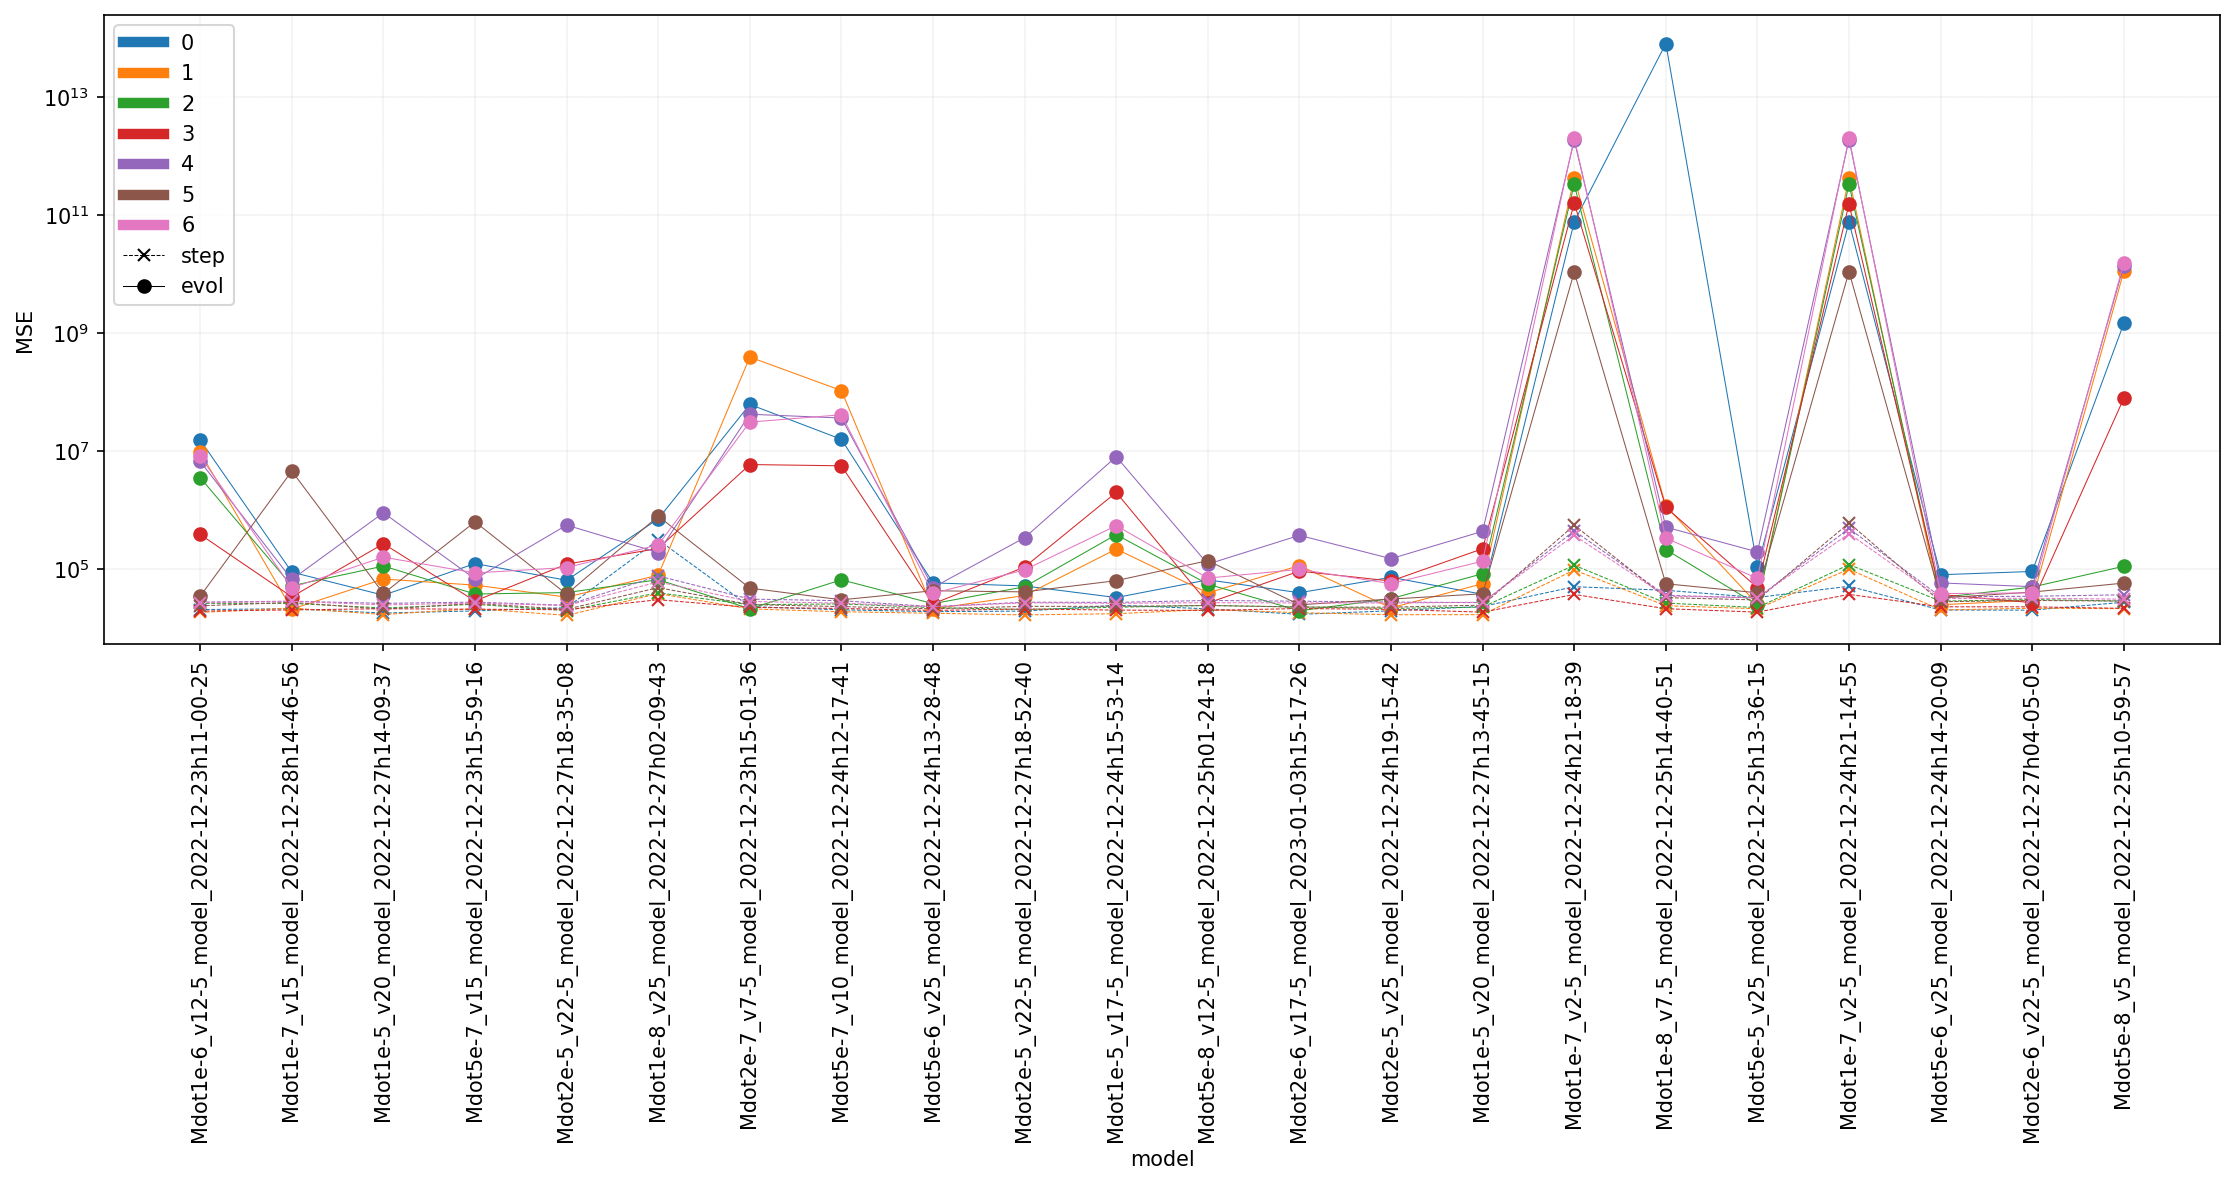

In [23]:
## NIEUWE VERSIE

idx = ['0', '1', '2','3', '4', '5', '6']
# idx = ['4', '5', '6']
outloc  = '/STER/silkem/MACE/models/CSE_0D/'

x = np.linspace(1,22,22)

fig = plt.figure(figsize = (15,8))
ax1 = fig.add_subplot((111))
lw = 0.5
handles = list()

specs = ['CO', 'H2O', 'HCN', 'H2S','C2H2', 'OH', 'CN', 'HS', 'C2H', 'CH3C5NH+']

for i in range(len(idx)):
    dirname = '20240106_102404_58729_'+idx[i]
    print('\n________'+dirname+'_______________________________________________\n\n')

    testpaths = train.testpath

    # testpaths = natsorted(testpaths)

    avg_step = list()
    std_step = list()
    sum_step = list()

    avg_evol = list()
    std_evol = list()
    sum_evol = list()

    res_step_sum = list()
    res_evol_sum = list()

    mods = list()

    for testpath in testpaths:
        print(testpath)
        meta, model, trainloss_, testloss_ = utils.load_all(outloc, dirname) # type: ignore

        input, info = ds.get_test_data(testpath,train)

        save = True
        title = info['path'] +'_'+ info['name']
        mods.append(title)

        n, n_hat, t, comptime = tr.test(model, input)
        start_idx = 0
        n_evol, mace_time = tr.test_evolution(model, input, start_idx=start_idx)

        print('\n>> Denormalising abundances...')
        n = ds.get_abs(n)
        n_hat = ds.get_abs(n_hat)
        n_evol = ds.get_abs(n_evol)

        res_step = utils.relative_error(n, n_hat)
        res_evol = utils.relative_error(n, n_evol)

        res_step_sum.append(res_step.sum())
        res_evol_sum.append(res_evol.sum())
        

        # specs_dict, idx_specs = utils.get_specs()

        # # for idx in range(res_evol.shape[1]):
        # for idx in range(1,468,50):
        #     plt.plot(res_evol[:,idx], label = str(idx)+' '+idx_specs[idx])
        # plt.legend()
        # plt.yscale('log')

        # # pl.plot_abs(n, n_evol, plots_path,title = '', specs = [], save = False)

        # print(res_evol.shape)
        # print(res_evol.sum())
        # xxx


    line, = ax1.plot(x,res_step_sum,marker ='x', linestyle = '--', lw = lw)
    ax1.plot(x,res_evol_sum,marker ='o', linestyle = '-',color = line.get_color(),  lw = lw)
    leg = mlines.Line2D([],[], color = line.get_color(), ls = '-' , lw = 5, label = idx[i])
    handles.append(leg)

ax1.set_yscale('log')

ax1.set_xlabel('model', fontsize = 10)
ax1.set_ylabel('MSE', fontsize = 10)

from matplotlib.ticker import FixedLocator
ax1.xaxis.set_major_locator(FixedLocator(x))
ax1.set_xticklabels(mods, rotation=90, fontsize = 10)

ax1.grid(True, linestyle='--', linewidth=0.1, color='gray')

l_step = mlines.Line2D([],[], color = 'k', ls = '--' , marker = 'x', label='step', lw = lw)
l_evol = mlines.Line2D([],[], color = 'k', ls = '-' , marker = 'o', label='evol', lw = lw)

handles.append(l_step)
handles.append(l_evol)

plt.legend(handles = handles, fontsize = 10)

plt.tight_layout()
plt.savefig('test_res.png')
plt.show()

In [5]:
idx = ['0', '1', '2','3', '4', '5', '6']

outloc  = '/STER/silkem/MACE/models/CSE_0D/'

loss_evol = list()
loss_step = list()
time_evol = list()
time_step = list()

for i in range(len(idx)):
    dirname = '20240106_102404_58729_'+idx[i]
    print('\n'+dirname+'_______________________________________________')  
    
    sum_step = 0
    sum_evol = 0
    evol_calctime = list()
    step_calctime = list()

    for i in range(len(train.testpath)):
        print(i,end='\r')

        testpath = train.testpath[i]
        # print(testpath)

        # print('>> Loading test data...')
        input, info = ds.get_test_data(testpath,train)

        # print('>> Running model')
        n, n_hat, t, mace_step_time = tr.test(model_testing, input)
        step_calctime.append(mace_step_time)
        n_evol, mace_evol_time = tr.test_evolution(model_testing, input, start_idx=0)
        evol_calctime.append(mace_evol_time)

        # print('>> Den ormalising abundances...')
        n = ds.get_abs(n)
        n_hat = ds.get_abs(n_hat)
        n_evol = ds.get_abs(n_evol)

        # print('>> Calculating & saving losses...')
        # print('per time step:')
        mse = loss.mse_loss(n[1:], n_hat)
        sum_step += mse.sum()

        # print('    evolution:')
        mse_evol = loss.mse_loss(n[1:], n_evol)
        sum_evol += mse_evol.sum()

    np.save(outloc+dirname+'/testloss_evol_' + str(len(train.testpath))+'.npy', np.array(sum_evol))
    np.save(outloc+dirname + '/testloss_step_' + str(len(train.testpath))+'.npy', np.array(sum_step))
    np.save(outloc + dirname + '/calctime_evol_' + str(len(train.testpath)) + '.npy', evol_calctime)
    np.save(outloc + dirname + '/calctime_step_' + str(len(train.testpath)) + '.npy', step_calctime)  
    loss_evol.append(sum_evol)
    loss_step.append(sum_step)
    time_evol.append(np.array(evol_calctime))
    time_step.append(np.array(step_calctime))



20240106_102404_58729_0_______________________________________________
3001
20240106_102404_58729_1_______________________________________________


KeyboardInterrupt: 

### Testing jacobian

In [152]:
model = nODE.Solver(p_dim=4,z_dim = z_dim, n_dim=n_dim, DEVICE = DEVICE)

z = torch.randn(134,10, requires_grad=True)
M = np.load('/STER/silkem/ChemTorch/rates/M_rate16.npy')

M = torch.from_numpy(M).to_sparse()



In [153]:
A = model.g.A
B = model.g.B
C = model.g.C
jac_D = jacobian(model.decoder,z, strategy='forward-mode', vectorize=True).view(468,134,134,-1)

In [152]:
tic = time()
ode = C + torch.einsum("ij, bj -> bi", A, z) + torch.einsum("ijk, bj, bk -> bi", B, z, z) 
toc = time()
print('time:', toc-tic)

time: 0.0006093978881835938


In [9]:
Aode = torch.einsum("ij, bj -> bi", A, z)
Aode.shape

torch.Size([134, 10])

In [148]:
Bode = torch.einsum("ijk, bj, bk -> bi", B, z, z)
Bode.shape

torch.Size([134, 10])

In [145]:
(z.unsqueeze(-1)* z.unsqueeze(1) ).shape

torch.Size([134, 10, 10])

In [154]:
tic = time()
Aode = z@A
Bode = (B @ (z.unsqueeze(-1) * z.unsqueeze(1)).T).sum()
toc = time()
print('time:', toc-tic)

print(C.shape , Aode.shape, Bode.shape)

ode = C+Aode+Bode



time: 0.0010347366333007812
torch.Size([10]) torch.Size([134, 10]) torch.Size([])


In [169]:

tic = time()
L0 = torch.einsum("NZ , Nbci , i   -> bcZ  ", M , jac_D , C)
L1 = torch.einsum("NZ , Nbci , ij  -> bcZj ", M , jac_D , A)
L2 = torch.einsum("NZ , Nbci , ijk -> bcZjk", M , jac_D , B)
toc = time()

print(toc-tic)
L0.shape, L1.shape, L2.shape

1.018272876739502


(torch.Size([134, 134, 14]),
 torch.Size([134, 134, 14, 10]),
 torch.Size([134, 134, 14, 10, 10]))

In [87]:
C.shape, A.shape, B.shape, z.shape, jac_D.shape, M.shape

(torch.Size([10]),
 torch.Size([10, 10]),
 torch.Size([10, 10, 10]),
 torch.Size([134, 10]),
 torch.Size([468, 134, 134, 10]),
 torch.Size([468, 14]))

In [177]:
tic = time()
L_0 = (jac_D @ C).T @ M
toc = time()
L_0.shape, toc-tic

(torch.Size([134, 134, 14]), 0.6680154800415039)

In [171]:
(L0-L_0).sum()

tensor(3.1974e-14, grad_fn=<SumBackward0>)

In [178]:
tic = time()
L_1 = (jac_D @ model.g.A).T @ M
toc = time()
L_1.shape, toc-tic

(torch.Size([10, 134, 134, 14]), 5.053350448608398)

In [173]:
(L1-L_1.view(134,134,-1,10)).sum()

tensor(0., grad_fn=<SumBackward0>)

In [193]:
L2 = (jac_D @ model.g.B)

RuntimeError: The size of tensor a (134) must match the size of tensor b (10) at non-singleton dimension 1

In [191]:
jac_D.shape, model.g.B.shape

(torch.Size([468, 134, 134, 10]), torch.Size([10, 10, 10]))

### Testing gradient loss

In [ ]:
model = nODE.Solver(p_dim=4,z_dim = z_dim, n_dim=n_dim, DEVICE = DEVICE)

z = torch.randn(134,10, requires_grad=True)
M = np.load('/STER/silkem/ChemTorch/rates/M_rate16.npy')

M = torch.from_numpy(M).to_sparse()



In [ ]:
A = model.g.A
B = model.g.B
C = model.g.C
jac_D = jacobian(model.decoder,z, strategy='forward-mode', vectorize=True).view(468,134,134,-1)

In [64]:
## import own functions
sys.path.insert(1, '/STER/silkem/ChemTorch/src/')
import ode.acodes   as odes
import rates    as rates
import input    as input

In [65]:
data = ds.CSEdata( nb_samples=10000, dt_fract=dt_fract)

i = 0
path = data.path[i]

n,p,dt = data[i]

path

'/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-8_v10_T_eps/models/model_2022-12-23h17-45-41/csfrac_smooth.out'

In [66]:
mod = ds.CSEmod(path)

In [67]:
dt_or, n_or, p_or = mod.split_in_0D()
n_or = np.clip(n_or, 1e-20, None)

In [68]:
n = ds.get_abs(n)
p = ds.get_phys(p, data)

In [69]:
(p-p_or).sum()

tensor(-1.1457e-08)

In [75]:
print(np.abs(n-n_or))

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         3.9968e-15],
        [1.3764e-21, 4.5438e-28, 2.7610e-29,  ..., 0.0000e+00, 8.6027e-23,
         3.9968e-15],
        [4.8704e-21, 6.5633e-28, 3.9443e-30,  ..., 0.0000e+00, 1.3235e-22,
         3.9968e-15],
        ...,
        [6.5052e-19, 1.6941e-21, 1.8933e-29,  ..., 0.0000e+00, 0.0000e+00,
         2.7200e-15],
        [6.5052e-19, 1.2705e-20, 1.8933e-29,  ..., 0.0000e+00, 2.3852e-18,
         2.7200e-15],
        [3.2526e-19, 8.4703e-22, 1.8933e-29,  ..., 0.0000e+00, 1.9516e-18,
         2.7200e-15]])


In [71]:
n

tensor([[1.0000e-20, 1.0000e-20, 1.0000e-20,  ..., 1.0000e-20, 1.0000e-20,
         5.0000e-01],
        [5.1950e-07, 2.9690e-13, 5.2490e-15,  ..., 1.0000e-20, 3.1180e-08,
         5.0000e-01],
        [1.1290e-06, 3.4390e-13, 6.2880e-15,  ..., 1.0000e-20, 5.9860e-08,
         5.0000e-01],
        ...,
        [3.4320e-04, 3.9550e-06, 1.2830e-14,  ..., 1.0000e-20, 5.1790e-04,
         4.9980e-01],
        [3.4390e-04, 4.3380e-06, 1.2830e-14,  ..., 1.0000e-20, 5.1830e-04,
         4.9980e-01],
        [3.4470e-04, 4.7510e-06, 1.2830e-14,  ..., 1.0000e-20, 5.1880e-04,
         4.9980e-01]])

In [72]:
n_or

array([[1.000e-20, 1.000e-20, 1.000e-20, ..., 1.000e-20, 1.000e-20,
        5.000e-01],
       [5.195e-07, 2.969e-13, 5.249e-15, ..., 1.000e-20, 3.118e-08,
        5.000e-01],
       [1.129e-06, 3.439e-13, 6.288e-15, ..., 1.000e-20, 5.986e-08,
        5.000e-01],
       ...,
       [3.432e-04, 3.955e-06, 1.283e-14, ..., 1.000e-20, 5.179e-04,
        4.998e-01],
       [3.439e-04, 4.338e-06, 1.283e-14, ..., 1.000e-20, 5.183e-04,
        4.998e-01],
       [3.447e-04, 4.751e-06, 1.283e-14, ..., 1.000e-20, 5.188e-04,
        4.998e-01]])

### Random testing

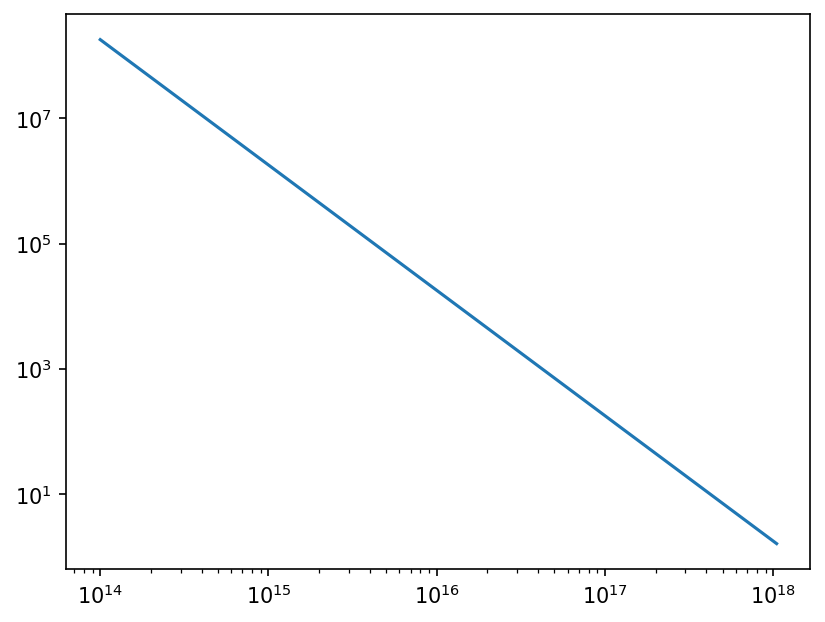

In [22]:
path = '/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-6_v12-5_T_eps/models/model_2022-12-23h11-00-25/csfrac_smooth.out'
mod = ds.CSEmod(path)

plt.loglog(mod.radius, mod.dens)

### Statistics of dataset


In [2]:
## Set up PyTorch 
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} 

lr = 1.e-4
epochs = 100

losstype = 'mse_idn'
# losstype = 'mse'
z_dim = 8
dt_fract = 0.2
batch_size = 1
nb_samples = 10000
n_dim = 468
nb_hidden = 1
ae_type = 'simple'
nb_test = 3000

print('------------------------------')
print('      # epochs:', epochs)
print(' learning rate:', lr)
print('# z dimensions:', z_dim)
print('     # samples:', nb_samples)
print('     loss type:', losstype)
print('')


train, test, data_loader, test_loader = ds.get_data(dt_fract=dt_fract,nb_samples=nb_samples,nb_test = nb_test, batch_size=batch_size, kwargs=kwargs)

------------------------------
      # epochs: 100
 learning rate: 0.0001
# z dimensions: 8
     # samples: 10000
     loss type: mse_idn

Dataset:
------------------------------
  total # of samples: 10000
#   training samples: 7000
# validation samples: 3000
               ratio: 0.3
     #  test samples: 3000


#### Mdot distribution dataset

In [40]:
mdot8 = list()
mdot7 = list()
mdot6 = list()
mdot5 = list()

for path in train.path:
    if path[56:57] == '8':
        mdot8.append(path)
    elif path[56:57] == '7':
        mdot7.append(path)
    elif path[56:57] == '6':
        mdot6.append(path)
    elif path[56:57] == '5':
        mdot5.append(path)

print(len(mdot8), len(mdot7), len(mdot6), len(mdot5))

1762 2112 1933 1193


In [35]:
mdot1_8 = list()
mdot2_8 = list()
mdot5_8 = list()

mdot1_7 = list()
mdot2_7 = list()
mdot5_7 = list()

mdot1_6 = list()
mdot2_6 = list()
mdot5_6 = list()

mdot1_5 = list()
mdot2_5 = list()
mdot5_5 = list()

for path in train.path:
    if path[53:57] == '1e-8':
        mdot1_8.append(path)
    elif path[53:57] == '2e-8':
        mdot2_8.append(path)
    elif path[53:57] == '5e-8':
        mdot5_8.append(path)
    elif path[53:57] == '1e-7':
        mdot1_7.append(path)
    elif path[53:57] == '2e-7':
        mdot2_7.append(path)
    elif path[53:57] == '5e-7':
        mdot5_7.append(path)
    elif path[53:57] == '1e-6':
        mdot1_6.append(path)
    elif path[53:57] == '2e-6':
        mdot2_6.append(path)
    elif path[53:57] == '5e-6':
        mdot5_6.append(path)
    elif path[53:57] == '1e-5':
        mdot1_5.append(path)
    elif path[53:57] == '2e-5':
        mdot2_5.append(path)
    elif path[53:57] == '5e-5':
        mdot5_5.append(path)

train_stats = [len(mdot1_8), len(mdot2_8), len(mdot5_8), len(mdot1_7), len(mdot2_7), len(mdot5_7), len(mdot1_6), len(mdot2_6), len(mdot5_6), len(mdot1_5), len(mdot2_5), len(mdot5_5)]


In [44]:
mdot1_8 = list()
mdot2_8 = list()
mdot5_8 = list()

mdot1_7 = list()
mdot2_7 = list()
mdot5_7 = list()

mdot1_6 = list()
mdot2_6 = list()
mdot5_6 = list()

mdot1_5 = list()
mdot2_5 = list()
mdot5_5 = list()

for path in train.testpath:
    if path[53:57] == '1e-8':
        mdot1_8.append(path)
    elif path[53:57] == '2e-8':
        mdot2_8.append(path)
    elif path[53:57] == '5e-8':
        mdot5_8.append(path)
    elif path[53:57] == '1e-7':
        mdot1_7.append(path)
    elif path[53:57] == '2e-7':
        mdot2_7.append(path)
    elif path[53:57] == '5e-7':
        mdot5_7.append(path)
    elif path[53:57] == '1e-6':
        mdot1_6.append(path)
    elif path[53:57] == '2e-6':
        mdot2_6.append(path)
    elif path[53:57] == '5e-6':
        mdot5_6.append(path)
    elif path[53:57] == '1e-5':
        mdot1_5.append(path)
    elif path[53:57] == '2e-5':
        mdot2_5.append(path)
    elif path[53:57] == '5e-5':
        mdot5_5.append(path)

test_stats = [len(mdot1_8), len(mdot2_8), len(mdot5_8), len(mdot1_7), len(mdot2_7), len(mdot5_7), len(mdot1_6), len(mdot2_6), len(mdot5_6), len(mdot1_5), len(mdot2_5), len(mdot5_5)]


In [36]:
mdot1_8 = list()
mdot2_8 = list()
mdot5_8 = list()

mdot1_7 = list()
mdot2_7 = list()
mdot5_7 = list()

mdot1_6 = list()
mdot2_6 = list()
mdot5_6 = list()

mdot1_5 = list()
mdot2_5 = list()
mdot5_5 = list()

for path in test.path:
    if path[53:57] == '1e-8':
        mdot1_8.append(path)
    elif path[53:57] == '2e-8':
        mdot2_8.append(path)
    elif path[53:57] == '5e-8':
        mdot5_8.append(path)
    elif path[53:57] == '1e-7':
        mdot1_7.append(path)
    elif path[53:57] == '2e-7':
        mdot2_7.append(path)
    elif path[53:57] == '5e-7':
        mdot5_7.append(path)
    elif path[53:57] == '1e-6':
        mdot1_6.append(path)
    elif path[53:57] == '2e-6':
        mdot2_6.append(path)
    elif path[53:57] == '5e-6':
        mdot5_6.append(path)
    elif path[53:57] == '1e-5':
        mdot1_5.append(path)
    elif path[53:57] == '2e-5':
        mdot2_5.append(path)
    elif path[53:57] == '5e-5':
        mdot5_5.append(path)

vald_stats = [len(mdot1_8), len(mdot2_8), len(mdot5_8), len(mdot1_7), len(mdot2_7), len(mdot5_7), len(mdot1_6), len(mdot2_6), len(mdot5_6), len(mdot1_5), len(mdot2_5), len(mdot5_5)]


In [37]:
loc = '/STER/silkem/MACE/'
paths = np.loadtxt(loc+'data/paths_data_C.txt', dtype=str)


mdot1_8 = list()
mdot2_8 = list()
mdot5_8 = list()

mdot1_7 = list()
mdot2_7 = list()
mdot5_7 = list()

mdot1_6 = list()
mdot2_6 = list()
mdot5_6 = list()

mdot1_5 = list()
mdot2_5 = list()
mdot5_5 = list()

print(len(paths))

for path in paths:
    if path[53:57] == '1e-8':
        mdot1_8.append(path)
    elif path[53:57] == '2e-8':
        mdot2_8.append(path)
    elif path[53:57] == '5e-8':
        mdot5_8.append(path)
    elif path[53:57] == '1e-7':
        mdot1_7.append(path)
    elif path[53:57] == '2e-7':
        mdot2_7.append(path)
    elif path[53:57] == '5e-7':
        mdot5_7.append(path)
    elif path[53:57] == '1e-6':
        mdot1_6.append(path)
    elif path[53:57] == '2e-6':
        mdot2_6.append(path)
    elif path[53:57] == '5e-6':
        mdot5_6.append(path)
    elif path[53:57] == '1e-5':
        mdot1_5.append(path)
    elif path[53:57] == '2e-5':
        mdot2_5.append(path)
    elif path[53:57] == '5e-5':
        mdot5_5.append(path)


tot_stats = [len(mdot1_8), len(mdot2_8), len(mdot5_8), len(mdot1_7), len(mdot2_7), len(mdot5_7), len(mdot1_6), len(mdot2_6), len(mdot5_6), len(mdot1_5), len(mdot2_5), len(mdot5_5)]


17998


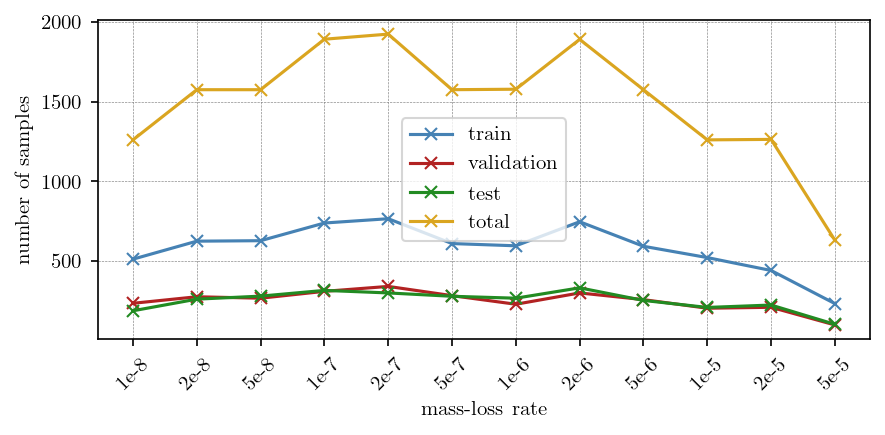

In [117]:
mdot = ['1e-8', '2e-8', '5e-8', '1e-7', '2e-7', '5e-7', '1e-6', '2e-6', '5e-6', '1e-5', '2e-5', '5e-5']

fig, ax1 = plt.subplots(1,1, figsize = (6,3))

# ax1.set_title('full dataset (18 000 samples)')

ax1.plot(train_stats, 'x-', color = 'steelblue', label = 'train')
ax1.plot(vald_stats, 'x-', color = 'firebrick', label = 'validation')
ax1.plot(test_stats, 'x-', color = 'forestgreen', label = 'test')
ax1.plot(tot_stats, 'x-', color = 'goldenrod', label = 'total')

ax1.set_xticks(np.arange(0,12,1))
ax1.set_xticklabels(mdot, rotation = 45)
ax1.set_ylabel('number of samples')
ax1.set_xlabel('mass-loss rate')

# ax1.set_yscale('log')


ax1.legend()

ax1.grid(True, linestyle='--', linewidth=0.3, color='gray')
plt.tight_layout()

plt.savefig('figs/distr_Mdot.png')

#### v distribution dataset

In [52]:
train.path[0][59:61]

'10'

In [58]:
v2 = list()
v5 = list()
v7 = list()

v10 = list()
v12 = list()
v15 = list()
v17 = list()

v20 = list()
v22 = list()
v25 = list()

rest = list()


for path in train.path:
    if path[59:61] == '2-' or path[59:61] == '2.':
        v2.append(path)
    elif path[59:61] == '5_':
        v5.append(path)
    elif path[59:61] == '7-' or path[59:61] == '7.':
        v7.append(path)
    elif path[59:61] == '10':
        v10.append(path)
    elif path[59:61] == '12':
        v12.append(path)
    elif path[59:61] == '15':
        v15.append(path)
    elif path[59:61] == '17':
        v17.append(path)
    elif path[59:61] == '20':
        v20.append(path)
    elif path[59:61] == '22':
        v22.append(path)
    elif path[59:61] == '25':
        v25.append(path)
    else:
        rest.append(path[59:61])

train_v = [len(v2), len(v5), len(v7), len(v10), len(v12), len(v15), len(v17), len(v20), len(v22), len(v25)]
sum = len(v2)+len(v5)+len(v7)+len(v10)+len(v12)+len(v15)+len(v17)+len(v20)+len(v22)+len(v25)


7000
[]


In [59]:
v2 = list()
v5 = list()
v7 = list()

v10 = list()
v12 = list()
v15 = list()
v17 = list()

v20 = list()
v22 = list()
v25 = list()

rest = list()


for path in test.path:
    if path[59:61] == '2-' or path[59:61] == '2.':
        v2.append(path)
    elif path[59:61] == '5_':
        v5.append(path)
    elif path[59:61] == '7-' or path[59:61] == '7.':
        v7.append(path)
    elif path[59:61] == '10':
        v10.append(path)
    elif path[59:61] == '12':
        v12.append(path)
    elif path[59:61] == '15':
        v15.append(path)
    elif path[59:61] == '17':
        v17.append(path)
    elif path[59:61] == '20':
        v20.append(path)
    elif path[59:61] == '22':
        v22.append(path)
    elif path[59:61] == '25':
        v25.append(path)
    else:
        rest.append(path[59:61])

vald_v = [len(v2), len(v5), len(v7), len(v10), len(v12), len(v15), len(v17), len(v20), len(v22), len(v25)]
sum = len(v2)+len(v5)+len(v7)+len(v10)+len(v12)+len(v15)+len(v17)+len(v20)+len(v22)+len(v25)


In [61]:
v2 = list()
v5 = list()
v7 = list()

v10 = list()
v12 = list()
v15 = list()
v17 = list()

v20 = list()
v22 = list()
v25 = list()

rest = list()


for path in paths:
    if path[59:61] == '2-' or path[59:61] == '2.':
        v2.append(path)
    elif path[59:61] == '5_':
        v5.append(path)
    elif path[59:61] == '7-' or path[59:61] == '7.':
        v7.append(path)
    elif path[59:61] == '10':
        v10.append(path)
    elif path[59:61] == '12':
        v12.append(path)
    elif path[59:61] == '15':
        v15.append(path)
    elif path[59:61] == '17':
        v17.append(path)
    elif path[59:61] == '20':
        v20.append(path)
    elif path[59:61] == '22':
        v22.append(path)
    elif path[59:61] == '25':
        v25.append(path)
    else:
        rest.append(path[59:61])

tot_v = [len(v2), len(v5), len(v7), len(v10), len(v12), len(v15), len(v17), len(v20), len(v22), len(v25)]
sum = len(v2)+len(v5)+len(v7)+len(v10)+len(v12)+len(v15)+len(v17)+len(v20)+len(v22)+len(v25)


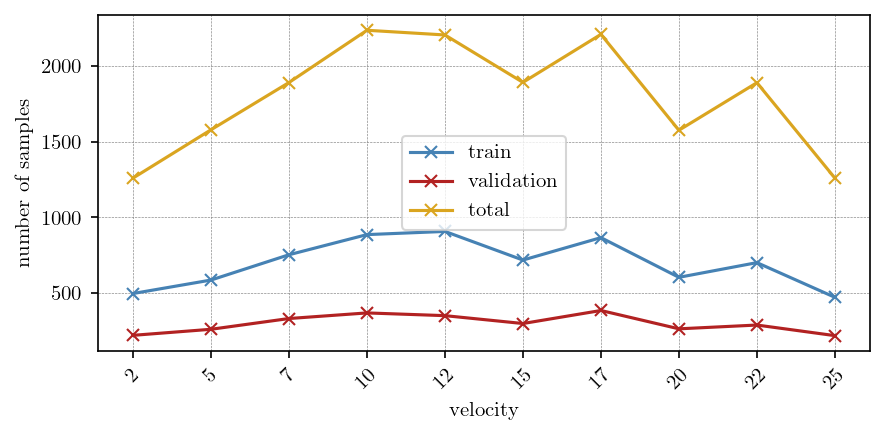

In [118]:
v = ['2', '5', '7', '10', '12', '15', '17', '20', '22', '25']

fig, ax1 = plt.subplots(1,1, figsize = (6,3))

# ax1.set_title('full dataset (18 000 samples)')

ax1.plot(train_v, 'x-', color = 'steelblue', label = 'train')
ax1.plot(vald_v, 'x-', color = 'firebrick', label = 'validation')
# ax1.plot(test_stats, 'x-', color = 'forestgreen', label = 'test')
ax1.plot(tot_v, 'x-', color = 'goldenrod', label = 'total')

ax1.set_xticks(np.arange(0,10,1))
ax1.set_xticklabels(v, rotation = 45)
ax1.set_ylabel('number of samples')
ax1.set_xlabel('velocity')

# ax1.set_yscale('log')


ax1.legend()

ax1.grid(True, linestyle='--', linewidth=0.3, color='gray')
plt.tight_layout()
plt.savefig('figs/distr_vexp.png')

#### Mdot, v -distribution

In [85]:
import astropy                  as apy
from astropy.constants import M_sun
from astropy import constants   as cst
## units & constants
Msun = M_sun.cgs.value      # gram
yr   = 31536000             # s
Msunyr = Msun/yr            # gram/s
cms  = 1e5

def density(Mdot,v,r):
    '''
    Input 
        - mass-loss rate (Mdot) in units of Msol/yr
        - outflow velocity (v) in units of km/s
        - radius (r): location of the outflow, inputs of cm
    Output
        - number density in units of cm^-3
    '''
    mu = 2.0 + 4.0*0.17
    mH = cst.u.to('g').value
    # r = 1e14 #* unt.cgs.cm                       # cm

    # r    = 1e18 #* unt.cgs.cm                       # cm
    # print(Mdot, Msunyr)
    Mdot = Mdot * Msunyr                            # gram/s
    vexp = v    * cms                               # cm/s

    dens = Mdot / (4*np.pi * vexp * r**2 * mu * mH)       # cm^-3

    # dens = dens * g_to_kg * cm_to_m**(-3)           # kg/m^3

    return dens

In [105]:

Mdot = ['1e-8' , '2e-8' , '5e-8' , '1e-7' , '2e-7' , '5e-7' , '1e-6' , '2e-6' , '5e-6' , '1e-5' , '2e-5' , '5e-5']
v    = ['2-'   , '5_'   , '7-'   , '10'   , '12'  , '15'  , '17'  , '20'  , '22'  , '25']
v2    = ['2-'   , '5_'   , '7.'   , '10'   , '12'  , '15'  , '17'  , '20'  , '22'  , '25']

Mdot_val = [1.e-8 , 2.e-8 , 5.e-8 , 1.e-7 , 2.e-7 , 5.e-7 , 1.e-6 , 2.e-6 , 5.e-6 , 1.e-5 , 2.e-5 , 5.e-5]
v_val    = [2.5   , 5.0   , 7.5   , 10.   , 12.5  , 15.0  , 17.5  , 20.0  , 22.5  , 25.0]


count = np.zeros((12,10))
dens = list()

for path in paths:

    j = path[53:57]
    i = path[59:61]

    if  (  (j == '2e-7' and i == '12') 
        or (j == '5e-6' and i == '20')
        or (j == '1e-5' and i == '20')  
        or (j == '2e-5' and i == '22') 
        or (j == '5e-7' and i == '12')  
        or (j == '2e-8' and i == '5_')    
        or (j == '1e-6' and i == '10')   
        or (j == '1e-6' and i == '12')
        or (j == '1e-7' and i == '5_')    
        or (j == '1e-7' and i == '12')
        or (j == '1e-8' and i == '5_')    
        or (j == '1e-8' and i == '10')   
        or (j == '2e-6' and i == '12') 
        or (j == '2e-7' and i == '5_')      
        or (j == '2e-7' and i == '10')
        or (j == '2e-8' and i == '2-') 
        or (j == '2e-8' and i == '10')  
        or (j == '2e-8' and i == '12') 
        or (j == '5e-7' and i == '10')   
        or (j == '5e-8' and i == '2-')  
        or (j == '5e-8' and i == '5_')    
        or (j == '5e-8' and i == '10')
        or (j == '1e-5' and i == '17') 
        or (j == '1e-6' and i == '17') 
        or (j == '2e-7' and i == '17')
        or (j == '2e-6' and i == '20')   
        or (j == '1e-6' and i == '20')   
        or (j == '5e-6' and i == '17')
        or (j == '5e-7' and i == '17') 
        or (j == '1e-5' and i == '22') 
        or (j == '2e-5' and i == '25')
        or (j == '2e-6' and i == '22') 
        or (j == '5e-6' and i == '22') 
        or (j == '5e-6' and i == '25')
        or (j == '5e-5' and i == '22') 
        or (j == '2e-7' and i == '10')   
        or (j == '5e-8' and i == '12')
        or (j == '1e-7' and i == '2-')  
        or (j == '2e-5' and i == '20')   
        or (j == '2e-5' and i == '17')
        or (j == '1e-5' and i == '25') 
        or (j == '1e-8' and i == '2-') 
        or (j == '5e-5' and i == '25') 
        or (j == '1e-7' and i == '10')  
        or (j == '2e-6' and i == '17') 
        or (j == '1e-8' and i == '7.') or (j == '1e-8' and i == '7-') 
        or (j == '2e-8' and i == '7.') or (j == '2e-8' and i == '7-') 
        or (j == '5e-8' and i == '7.') or (j == '5e-8' and i == '7-') 
        or (j == '1e-7' and i == '7.') or (j == '1e-7' and i == '7-')
        or (j == '2e-7' and i == '7.') or (j == '2e-7' and i == '7-')
        or (j == '5e-7' and i == '7.') or (j == '5e-7' and i == '7-')
        or (j == '1e-7' and i == '15') 
        or (j == '2e-7' and i == '15') 
        or (j == '5e-7' and i == '15') 
        or (j == '1e-6' and i == '15') 
        or (j == '2e-6' and i == '15') 
        or (j == '5e-6' and i == '15')     ):
            
            if i[-1] != '.':
                idx_mdot = Mdot.index(j)
                idx_v    = v.index(i)
                count[idx_mdot,idx_v] += 1 


                mdot = Mdot_val[idx_mdot]
                vel    = v_val[idx_v]
                dens.append(np.log10(density(mdot,vel,1e16)))
            else:
                idx_mdot = Mdot.index(j)
                idx_v    = v2.index(i)
                count[idx_mdot,idx_v] += 1 


                mdot = Mdot_val[idx_mdot]
                vel    = v_val[idx_v]
                dens.append(np.log10(density(mdot,vel,1e16)))

count = np.flip(count, axis=0)





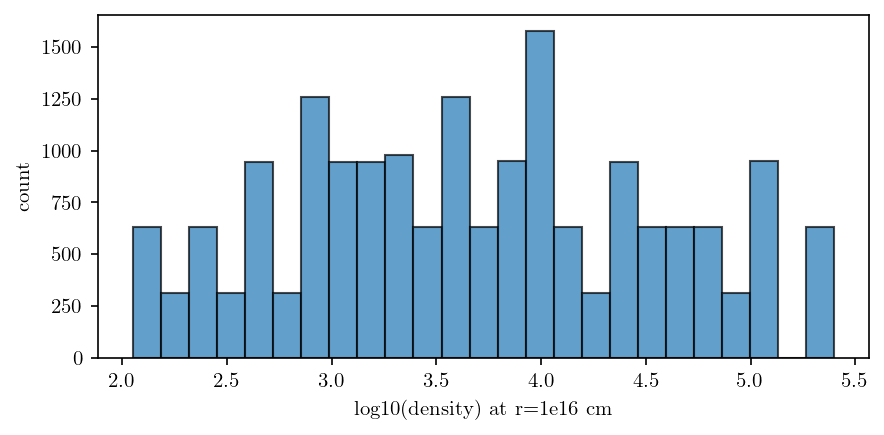

In [119]:
fig, ax1 = plt.subplots(1,1, figsize = (6,3))

ax1.hist(dens, bins = 25, edgecolor = 'black', alpha = 0.7)

ax1.set_ylabel('count')
ax1.set_xlabel('log10(density) at r=1e16 cm')


plt.tight_layout()
plt.savefig('figs/density_hist.png')


plt.show()

/tmp/ipykernel_93780/2099447267.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('GnBu')


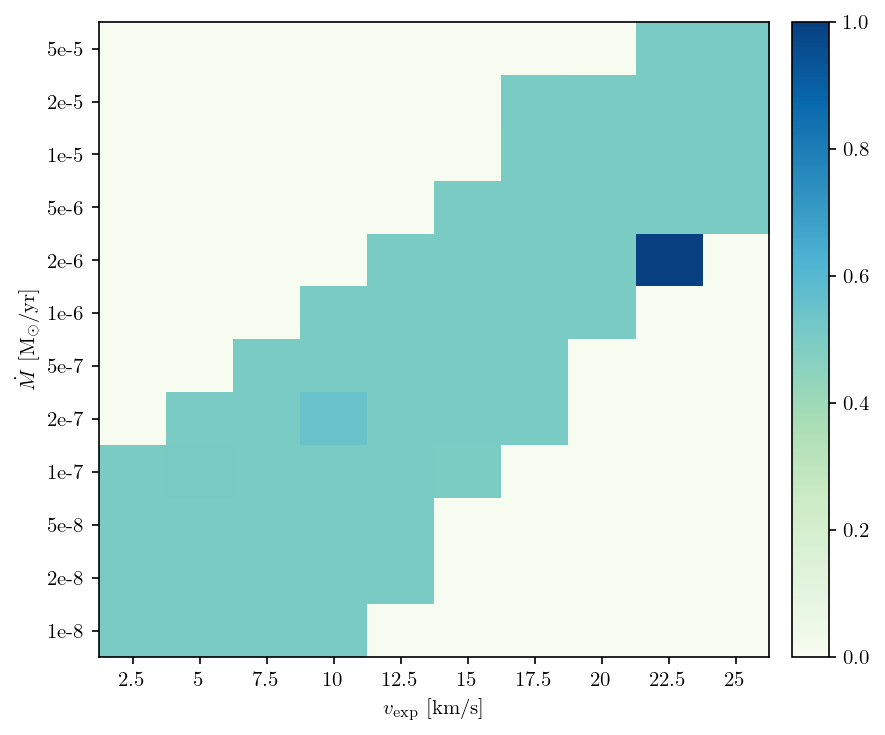

In [120]:
import matplotlib.cm as cm

fig, axs = plt.subplots(1,2, gridspec_kw={'width_ratios': [18,1]},figsize=(6, 5))
ax1 = axs[0]

cbax = axs[1]
cmap = cm.get_cmap('GnBu')
cb = fig.colorbar(mpl.cm.ScalarMappable( cmap=cmap), cax=cbax, orientation='vertical')

ax1.imshow(count, cmap=cmap, aspect='auto', interpolation='none')



ax1.xaxis.set_major_locator(FixedLocator([0, 1,2,3,4,5,6,7,8,9]))
ax1.yaxis.set_major_locator(FixedLocator([0,1,2,3,4,5,6,7,8,9,10,11]))
ax1.set_xticklabels([ '2.5', '5', '7.5', '10', '12.5', '15', '17.5', '20', '22.5', '25'])
arr = ['1e-8', '2e-8', '5e-8', '1e-7', '2e-7', '5e-7', '1e-6', '2e-6', '5e-6', '1e-5', '2e-5', '5e-5']
ax1.set_yticklabels(arr[::-1])
ax1.set_xlabel('$v_{\\rm exp}$ [km/s]')
ax1.set_ylabel('$\\dot{M}\ {\\rm[M_{\\odot}/yr]}$')


plt.tight_layout()
plt.savefig('figs/density_count_Mdot_v.png')

plt.show()